In [3]:
run import_packages.ipynb

success


## Public Functions

In [31]:


def distance_compute(lat1,lon1,lat2,lon2):
    dL = lon2 - lon1
    X = math.cos(lat2) * math.sin(dL)
    Y =math.cos(lat1) * math.sin(lat2) - math.sin(lat1) * math.cos(lat2) * math.cos(dL)
    bearing = np.arctan2(X, Y)
    bearing = np.degrees(bearing)
    if bearing<0:
        bearing=bearing+360

    R = 6373.0

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = math.sin(dlat / 2) ** 2 + math.cos(lat1) *math. cos(lat2) * math.sin(dlon / 2) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    d = R * c


    return d,bearing

def t_d_bearing_compute(data):
    from datetime import datetime
    delta_t_list=[]
    delta_d_list=[]
    brearing_list=[]
    if len(data)>=2:
        for i in range(0,len(data)-1):
            last=data['end'].values[i]
            new=data['start'].values[i+1]
            delta_t=(datetime.fromtimestamp(new)-datetime.fromtimestamp(last)).total_seconds()/60
            delta_d,bearing=distance_compute(data['latitude'].values[i],data['longitude'].values[i],data['latitude'].values[i+1],data['longitude'].values[i+1])
            delta_t_list.append(delta_t)
            delta_d_list.append(delta_d)
            brearing_list.append(bearing)
    return delta_t_list,delta_d_list,brearing_list


def lognormal_function( x, a, mu, sigma ):
    return a / x * 1. / (sigma * np.sqrt( 2. * np.pi ) ) * np.exp( -( np.log( x ) - mu )**2 / ( 2. * sigma**2 ) )


def fitting_lognormal(x,y,y_raw):
    #popt, _= curve_fit(lognormal_function, np.log10(np.asarray(x)+0.000001),np.log10(np.asarray(y)+0.00001),p0=[1,-0.1,0.1], maxfev=10000)
    popt, _ = curve_fit(lognormal_function,np.asarray(x),np.asarray(y),p0=[np.max(y),0,0.5], maxfev=2000000)
    a, b,c = popt
    print(a,b,c)
    x_line = [i for i in range(1, 10000)]
    y_line = lognormal_function(x_line, a, b,c)
    #print(y_line)
    return b, x_line,y_line

def linear_fun(x, a, b):
	return a * np.asarray(x)+b

def fitting(x,y):
    popt, _ = curve_fit(linear_fun, np.log10(np.asarray(x)+0.000001),np.log10(np.asarray(y)+0.00001),maxfev=10000)
    a,b=popt
    x_line = np.asarray(x)+0.000001
    # calculate the output for the range
    y_line = linear_fun(np.log10(x_line), a, b)
    y_line=[np.power(10,i) for i in y_line]
    return a,b,x_line, y_line

# Section 1. Analyze the record dataset (Raw)

getting the statistics of users, records, dmographic, home locations

# Section 2. Analyze the stoppoints dataset

getting the statistics of trajecotry

travel time, travel distance, travel angle, stay duration, 

In [4]:
import glob
#######Input Data
####demo_data: race distribution at counties
demo_data=pd.read_csv('/Volumes/SeagateDrive/US_demographic/CC-EST2020-ALLDATA.csv',encoding = "ISO-8859-1")
####stoppoints data for all individuals
path = r'/Users/lucinezhong/Documents/Stoppoint_Individual/individual_stopoints'  # use your path
all_files = glob.glob(os.path.join(path, "*.csv")) 
all_df= (pd.read_csv(f) for f in all_files)


path_external='/Volumes/SeagateDrive/'###saving and read files at external storage

/Users/lucinezhong/.conda/envs/PDE-COVID/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning:

Columns (7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79) have mixed types.Specify dtype option on import or set low_memory=False.



## Section 2.1. Demogrpahic_analyze_plot

In [ ]:
######finding each demographic info, like home_location, race
def demographic_analyze(demo_data,all_df):
    '''
    :param demo_data: distribution of race 
    :all_df: all individuals' stopoints
    return demographic info for each individal and his/her possible race
    
    '''
    ####results write in text
    f=open(pathx+'Trajecotry_Data_summary/users_demographic.txt','a')
    print('id',",",'home_lat',",",'home_lon',",",'home_cty',",",'home_state',",",'cty_race',file=f)
    cty_race,demo_data=county_major_race(demo_data)
    count=0
    for df in all_df:
        count+=1
        try:
            df['date'] = [datetime.datetime.fromtimestamp(i) for i in df['start']]
            home_lat,home_lon= finding_home_locations(df)
            #print(home_lat,home_lon)
            cty,state=finding_home_city(str(home_lat),str(home_lon))
            #print(cty,state)
            if state in list(demo_data['STNAME']) and cty in list(demo_data['CTYNAME']):
                race=demo_data[(demo_data['STNAME']==state) &(demo_data['CTYNAME']==cty)]['major_race'].values[0]
            else:
                #print('no pair')
                race = 'Non-hispanic White'  ###default case
            #print(count,df['id_indiv'].values[0],race)
            ####writing in txt
            print(df['id_indiv'].values[0],",",home_lat,",",home_lon,",",cty,",",state,",",race, file=f)
        except:
            ####writing in txt
            print(df['id_indiv'].values[0],",","none",",","none",",","none",",","none",",","none", file=f)
    f.close()
    df_demographic = pd.read_csv(path_external+'Trajecotry_Data_summary/users_demographic.txt',sep=" ,")
    df_demographic.to_csv(path_external+'Trajecotry_Data_summary/users_demographic.csv')

demographic_analyze(demo_data,all_df)

[0.5882338271235473, 0.25273080951668414, 0.12696393835103995, 0.012668961045438675, 0.0033168736595341414, 0.0007731058905681081, 0.0]


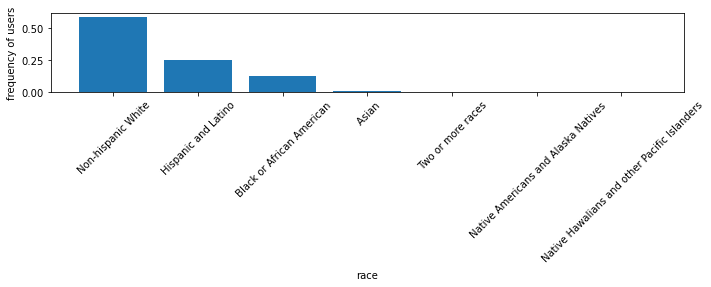

In [14]:
#######plotting the distribution of demographic

def demographic_plot(df_demographic):
    fig= plt.figure(figsize=(10, 4))
    langs =[' Non-hispanic White',' Hispanic and Latino',' Black or African American',' Asian',' Two or more races',' Native Americans and Alaska Natives',' Native Hawalians and other Pacific Islanders']
    counts_list=[]
    for i in langs:
        counts_list.append(len(df_demographic[df_demographic[' cty_race']==i])/len(df_demographic))
    print(counts_list)
    plt.bar(langs, counts_list)
    plt.xlabel("race")
    plt.ylabel("frequency of users")
    plt.xticks(rotation=45,fontsize=10)
    plt.tight_layout()
    fig.savefig('Data_analyse/demographic_user_all.png', dpi=2000)

df_demographic=pd.read_csv(path_external+'Trajecotry_Data_summary/users_demographic.csv')
demographic_plot(df_demographic)

## Section 2.2 trajectory_analyze(travel_t, travel_d,stay_t,travel_angle)

In [49]:
####stoppints analyze
from datetime import datetime

def stopoints_analyze(df_demographic,all_df):
    ''' read all individuals' stoppoint data
    :return: 
    1) individuals' intervals of time and intervals of distance
    2） statistic summary of:
    indiviudals' activity hours (t_start_end);
    average stay time  (ave_stay_t);
    average between-points-interval time ('ave_inter_t');
    number of soptpoints (#loc)
    burstness (burstness)

    '''
    #####df_output: All individuals (statstitics)
    columns=['id','t_start_end','ave_travel_t','ave_stay_t','#loc','burstness']
    
    df_output_array=[]
    for df, index in zip(all_df,np.arange(len(all_files))):
        print(index)
        df = df[df.label != -1]
        loc=df['label'].max()
        id_num=df['id_indiv'].values[0]
        
        df['d_home'] = [-1]*len(df)
        df['is_home'] = [-1]*len(df)
        if id_num in df_demographic['id'].values:
            home_lat=df_demographic[df_demographic['id']==id_num][' home_lat'].values[0]
            home_lon = df_demographic[df_demographic['id'] == id_num][' home_lon'].values[0]
            if home_lat!=' none' and home_lon!=' none':
                df['d_home']=[distance_compute(i, j, float(home_lat), float(home_lon))[0] for (i, j) in zip(df['latitude'], df['longitude'])] 
                df['is_home'] = [1 if d< 30/1000 else -1 for d in df['d_home']] ###1 is at home, -1 is not at home
                
        df['stay_t']=[(datetime.fromtimestamp(j)-datetime.fromtimestamp(i)).total_seconds()/60 for i,j in zip(df['start'],df['end'])]
        ave_stay_t=df['stay_t'].mean()
        
        df['date']=[str(datetime.fromtimestamp(i))[0:10] for i in df['start']]
        start_end=[]
        interval_t=list()
        interval_d=list()
        interval_a=list()
        for date in pd.unique(df['date']):
            df_temp=df[df['date']==date]
            start=df_temp['start'].values[0]
            end=df_temp['end'].values[-1]
            start_end.append((datetime.fromtimestamp(end)-datetime.fromtimestamp(start)).total_seconds()/60)
            delta_t_list, delta_d_list,brearing_list=t_d_bearing_compute(df_temp)
            interval_d = interval_d+list(delta_d_list)+[-1]
            interval_t=interval_t+list(delta_t_list)+[-1]
            interval_a=interval_a+list(brearing_list)+[-1]
        t_start_end=np.mean(start_end)
        df['travel_t(min)'] =interval_t
        df['travel_d(km)']=interval_d
        df['travel_beraing'] = interval_a

        if interval_t==[]:
            burstness=0
            ave_inter_t = 0
        else:
            ave_inter_t = np.mean(interval_t)
            si = np.mean(interval_t)
            mi = np.std(interval_t)
            burstness = (si - mi) / (si + mi)
        df.to_csv(path_external+'Stoppoint_Individual/individual_stoppoints_w_intervals/'+str(id_num)+'.csv')
        
        df_output_array.append([int(id_num), t_start_end, ave_inter_t, ave_stay_t, int(loc), burstness])
    df_output_array=np.array(df_output_array,dtype=object)
    df_output= pd.DataFrame(data=df_output_array,columns=columns)         
    df_output.to_csv(path_external+'Trajecotry_Data_summary/statistics_users_stoppints.csv')

######start preprocess the travel intervels and stay intervals
print('-----start preprocess the travel intervels and stay intervals----')

df_demographic = pd.read_csv(path_external + 'Trajecotry_Data_summary/users_demographic.csv')
stopoints_analyze(df_demographic,all_df)
print('-----end preprocess----')

-----start preprocess the travel intervels and stay intervals----
0
1


/Users/lucinezhong/.conda/envs/PDE-COVID/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/lucinezhong/.conda/envs/PDE-COVID/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/Users/lucinezhong/.conda/envs/PDE-COVID/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = 

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062
2063


3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701
3702
3703
3704
3705


5147
5148
5149
5150
5151
5152
5153
5154
5155
5156
5157
5158
5159
5160
5161
5162
5163
5164
5165
5166
5167
5168
5169
5170
5171
5172
5173
5174
5175
5176
5177
5178
5179
5180
5181
5182
5183
5184
5185
5186
5187
5188
5189
5190
5191
5192
5193
5194
5195
5196
5197
5198
5199
5200
5201
5202
5203
5204
5205
5206
5207
5208
5209
5210
5211
5212
5213
5214
5215
5216
5217
5218
5219
5220
5221
5222
5223
5224
5225
5226
5227
5228
5229
5230
5231
5232
5233
5234
5235
5236
5237
5238
5239
5240
5241
5242
5243
5244
5245
5246
5247
5248
5249
5250
5251
5252
5253
5254
5255
5256
5257
5258
5259
5260
5261
5262
5263
5264
5265
5266
5267
5268
5269
5270
5271
5272
5273
5274
5275
5276
5277
5278
5279
5280
5281
5282
5283
5284
5285
5286
5287
5288
5289
5290
5291
5292
5293
5294
5295
5296
5297
5298
5299
5300
5301
5302
5303
5304
5305
5306
5307
5308
5309
5310
5311
5312
5313
5314
5315
5316
5317
5318
5319
5320
5321
5322
5323
5324
5325
5326
5327
5328
5329
5330
5331
5332
5333
5334
5335
5336
5337
5338
5339
5340
5341
5342
5343
5344
5345
5346


6787
6788
6789
6790
6791
6792
6793
6794
6795
6796
6797
6798
6799
6800
6801
6802
6803
6804
6805
6806
6807
6808
6809
6810
6811
6812
6813
6814
6815
6816
6817
6818
6819
6820
6821
6822
6823
6824
6825
6826
6827
6828
6829
6830
6831
6832
6833
6834
6835
6836
6837
6838
6839
6840
6841
6842
6843
6844
6845
6846
6847
6848
6849
6850
6851
6852
6853
6854
6855
6856
6857
6858
6859
6860
6861
6862
6863
6864
6865
6866
6867
6868
6869
6870
6871
6872
6873
6874
6875
6876
6877
6878
6879
6880
6881
6882
6883
6884
6885
6886
6887
6888
6889
6890
6891
6892
6893
6894
6895
6896
6897
6898
6899
6900
6901
6902
6903
6904
6905
6906
6907
6908
6909
6910
6911
6912
6913
6914
6915
6916
6917
6918
6919
6920
6921
6922
6923
6924
6925
6926
6927
6928
6929
6930
6931
6932
6933
6934
6935
6936
6937
6938
6939
6940
6941
6942
6943
6944
6945
6946
6947
6948
6949
6950
6951
6952
6953
6954
6955
6956
6957
6958
6959
6960
6961
6962
6963
6964
6965
6966
6967
6968
6969
6970
6971
6972
6973
6974
6975
6976
6977
6978
6979
6980
6981
6982
6983
6984
6985
6986


8427
8428
8429
8430
8431
8432
8433
8434
8435
8436
8437
8438
8439
8440
8441
8442
8443
8444
8445
8446
8447
8448
8449
8450
8451
8452
8453
8454
8455
8456
8457
8458
8459
8460
8461
8462
8463
8464
8465
8466
8467
8468
8469
8470
8471
8472
8473
8474
8475
8476
8477
8478
8479
8480
8481
8482
8483
8484
8485
8486
8487
8488
8489
8490
8491
8492
8493
8494
8495
8496
8497
8498
8499
8500
8501
8502
8503
8504
8505
8506
8507
8508
8509
8510
8511
8512
8513
8514
8515
8516
8517
8518
8519
8520
8521
8522
8523
8524
8525
8526
8527
8528
8529
8530
8531
8532
8533
8534
8535
8536
8537
8538
8539
8540
8541
8542
8543
8544
8545
8546
8547
8548
8549
8550
8551
8552
8553
8554
8555
8556
8557
8558
8559
8560
8561
8562
8563
8564
8565
8566
8567
8568
8569
8570
8571
8572
8573
8574
8575
8576
8577
8578
8579
8580
8581
8582
8583
8584
8585
8586
8587
8588
8589
8590
8591
8592
8593
8594
8595
8596
8597
8598
8599
8600
8601
8602
8603
8604
8605
8606
8607
8608
8609
8610
8611
8612
8613
8614
8615
8616
8617
8618
8619
8620
8621
8622
8623
8624
8625
8626


10056
10057
10058
10059
10060
10061
10062
10063
10064
10065
10066
10067
10068
10069
10070
10071
10072
10073
10074
10075
10076
10077
10078
10079
10080
10081
10082
10083
10084
10085
10086
10087
10088
10089
10090
10091
10092
10093
10094
10095
10096
10097
10098
10099
10100
10101
10102
10103
10104
10105
10106
10107
10108
10109
10110
10111
10112
10113
10114
10115
10116
10117
10118
10119
10120
10121
10122
10123
10124
10125
10126
10127
10128
10129
10130
10131
10132
10133
10134
10135
10136
10137
10138
10139
10140
10141
10142
10143
10144
10145
10146
10147
10148
10149
10150
10151
10152
10153
10154
10155
10156
10157
10158
10159
10160
10161
10162
10163
10164
10165
10166
10167
10168
10169
10170
10171
10172
10173
10174
10175
10176
10177
10178
10179
10180
10181
10182
10183
10184
10185
10186
10187
10188
10189
10190
10191
10192
10193
10194
10195
10196
10197
10198
10199
10200
10201
10202
10203
10204
10205
10206
10207
10208
10209
10210
10211
10212
10213
10214
10215
10216
10217
10218
10219
10220
10221
1022

11423
11424
11425
11426
11427
11428
11429
11430
11431
11432
11433
11434
11435
11436
11437
11438
11439
11440
11441
11442
11443
11444
11445
11446
11447
11448
11449
11450
11451
11452
11453
11454
11455
11456
11457
11458
11459
11460
11461
11462
11463
11464
11465
11466
11467
11468
11469
11470
11471
11472
11473
11474
11475
11476
11477
11478
11479
11480
11481
11482
11483
11484
11485
11486
11487
11488
11489
11490
11491
11492
11493
11494
11495
11496
11497
11498
11499
11500
11501
11502
11503
11504
11505
11506
11507
11508
11509
11510
11511
11512
11513
11514
11515
11516
11517
11518
11519
11520
11521
11522
11523
11524
11525
11526
11527
11528
11529
11530
11531
11532
11533
11534
11535
11536
11537
11538
11539
11540
11541
11542
11543
11544
11545
11546
11547
11548
11549
11550
11551
11552
11553
11554
11555
11556
11557
11558
11559
11560
11561
11562
11563
11564
11565
11566
11567
11568
11569
11570
11571
11572
11573
11574
11575
11576
11577
11578
11579
11580
11581
11582
11583
11584
11585
11586
11587
11588
1158

12791
12792
12793
12794
12795
12796
12797
12798
12799
12800
12801
12802
12803
12804
12805
12806
12807
12808
12809
12810
12811
12812
12813
12814
12815
12816
12817
12818
12819
12820
12821
12822
12823
12824
12825
12826
12827
12828
12829
12830
12831
12832
12833
12834
12835
12836
12837
12838
12839
12840
12841
12842
12843
12844
12845
12846
12847
12848
12849
12850
12851
12852
12853
12854
12855
12856
12857
12858
12859
12860
12861
12862
12863
12864
12865
12866
12867
12868
12869
12870
12871
12872
12873
12874
12875
12876
12877
12878
12879
12880
12881
12882
12883
12884
12885
12886
12887
12888
12889
12890
12891
12892
12893
12894
12895
12896
12897
12898
12899
12900
12901
12902
12903
12904
12905
12906
12907
12908
12909
12910
12911
12912
12913
12914
12915
12916
12917
12918
12919
12920
12921
12922
12923
12924
12925
12926
12927
12928
12929
12930
12931
12932
12933
12934
12935
12936
12937
12938
12939
12940
12941
12942
12943
12944
12945
12946
12947
12948
12949
12950
12951
12952
12953
12954
12955
12956
1295

14158
14159
14160
14161
14162
14163
14164
14165
14166
14167
14168
14169
14170
14171
14172
14173
14174
14175
14176
14177
14178
14179
14180
14181
14182
14183
14184
14185
14186
14187
14188
14189
14190
14191
14192
14193
14194
14195
14196
14197
14198
14199
14200
14201
14202
14203
14204
14205
14206
14207
14208
14209
14210
14211
14212
14213
14214
14215
14216
14217
14218
14219
14220
14221
14222
14223
14224
14225
14226
14227
14228
14229
14230
14231
14232
14233
14234
14235
14236
14237
14238
14239
14240
14241
14242
14243
14244
14245
14246
14247
14248
14249
14250
14251
14252
14253
14254
14255
14256
14257
14258
14259
14260
14261
14262
14263
14264
14265
14266
14267
14268
14269
14270
14271
14272
14273
14274
14275
14276
14277
14278
14279
14280
14281
14282
14283
14284
14285
14286
14287
14288
14289
14290
14291
14292
14293
14294
14295
14296
14297
14298
14299
14300
14301
14302
14303
14304
14305
14306
14307
14308
14309
14310
14311
14312
14313
14314
14315
14316
14317
14318
14319
14320
14321
14322
14323
1432

15525
15526
15527
15528
15529
15530
15531
15532
15533
15534
15535
15536
15537
15538
15539
15540
15541
15542
15543
15544
15545
15546
15547
15548
15549
15550
15551
15552
15553
15554
15555
15556
15557
15558
15559
15560
15561
15562
15563
15564
15565
15566
15567
15568
15569
15570
15571
15572
15573
15574
15575
15576
15577
15578
15579
15580
15581
15582
15583
15584
15585
15586
15587
15588
15589
15590
15591
15592
15593
15594
15595
15596
15597
15598
15599
15600
15601
15602
15603
15604
15605
15606
15607
15608
15609
15610
15611
15612
15613
15614
15615
15616
15617
15618
15619
15620
15621
15622
15623
15624
15625
15626
15627
15628
15629
15630
15631
15632
15633
15634
15635
15636
15637
15638
15639
15640
15641
15642
15643
15644
15645
15646
15647
15648
15649
15650
15651
15652
15653
15654
15655
15656
15657
15658
15659
15660
15661
15662
15663
15664
15665
15666
15667
15668
15669
15670
15671
15672
15673
15674
15675
15676
15677
15678
15679
15680
15681
15682
15683
15684
15685
15686
15687
15688
15689
15690
1569

16894
16895
16896
16897
16898
16899
16900
16901
16902
16903
16904
16905
16906
16907
16908
16909
16910
16911
16912
16913
16914
16915
16916
16917
16918
16919
16920
16921
16922
16923
16924
16925
16926
16927
16928
16929
16930
16931
16932
16933
16934
16935
16936
16937
16938
16939
16940
16941
16942
16943
16944
16945
16946
16947
16948
16949
16950
16951
16952
16953
16954
16955
16956
16957
16958
16959
16960
16961
16962
16963
16964
16965
16966
16967
16968
16969
16970
16971
16972
16973
16974
16975
16976
16977
16978
16979
16980
16981
16982
16983
16984
16985
16986
16987
16988
16989
16990
16991
16992
16993
16994
16995
16996
16997
16998
16999
17000
17001
17002
17003
17004
17005
17006
17007
17008
17009
17010
17011
17012
17013
17014
17015
17016
17017
17018
17019
17020
17021
17022
17023
17024
17025
17026
17027
17028
17029
17030
17031
17032
17033
17034
17035
17036
17037
17038
17039
17040
17041
17042
17043
17044
17045
17046
17047
17048
17049
17050
17051
17052
17053
17054
17055
17056
17057
17058
17059
1706

18262
18263
18264
18265
18266
18267
18268
18269
18270
18271
18272
18273
18274
18275
18276
18277
18278
18279
18280
18281
18282
18283
18284
18285
18286
18287
18288
18289
18290
18291
18292
18293
18294
18295
18296
18297
18298
18299
18300
18301
18302
18303
18304
18305
18306
18307
18308
18309
18310
18311
18312
18313
18314
18315
18316
18317
18318
18319
18320
18321
18322
18323
18324
18325
18326
18327
18328
18329
18330
18331
18332
18333
18334
18335
18336
18337
18338
18339
18340
18341
18342
18343
18344
18345
18346
18347
18348
18349
18350
18351
18352
18353
18354
18355
18356
18357
18358
18359
18360
18361
18362
18363
18364
18365
18366
18367
18368
18369
18370
18371
18372
18373
18374
18375
18376
18377
18378
18379
18380
18381
18382
18383
18384
18385
18386
18387
18388
18389
18390
18391
18392
18393
18394
18395
18396
18397
18398
18399
18400
18401
18402
18403
18404
18405
18406
18407
18408
18409
18410
18411
18412
18413
18414
18415
18416
18417
18418
18419
18420
18421
18422
18423
18424
18425
18426
18427
1842

19631
19632
19633
19634
19635
19636
19637
19638
19639
19640
19641
19642
19643
19644
19645
19646
19647
19648
19649
19650
19651
19652
19653
19654
19655
19656
19657
19658
19659
19660
19661
19662
19663
19664
19665
19666
19667
19668
19669
19670
19671
19672
19673
19674
19675
19676
19677
19678
19679
19680
19681
19682
19683
19684
19685
19686
19687
19688
19689
19690
19691
19692
19693
19694
19695
19696
19697
19698
19699
19700
19701
19702
19703
19704
19705
19706
19707
19708
19709
19710
19711
19712
19713
19714
19715
19716
19717
19718
19719
19720
19721
19722
19723
19724
19725
19726
19727
19728
19729
19730
19731
19732
19733
19734
19735
19736
19737
19738
19739
19740
19741
19742
19743
19744
19745
19746
19747
19748
19749
19750
19751
19752
19753
19754
19755
19756
19757
19758
19759
19760
19761
19762
19763
19764
19765
19766
19767
19768
19769
19770
19771
19772
19773
19774
19775
19776
19777
19778
19779
19780
19781
19782
19783
19784
19785
19786
19787
19788
19789
19790
19791
19792
19793
19794
19795
19796
1979

21001
21002
21003
21004
21005
21006
21007
21008
21009
21010
21011
21012
21013
21014
21015
21016
21017
21018
21019
21020
21021
21022
21023
21024
21025
21026
21027
21028
21029
21030
21031
21032
21033
21034
21035
21036
21037
21038
21039
21040
21041
21042
21043
21044
21045
21046
21047
21048
21049
21050
21051
21052
21053
21054
21055
21056
21057
21058
21059
21060
21061
21062
21063
21064
21065
21066
21067
21068
21069
21070
21071
21072
21073
21074
21075
21076
21077
21078
21079
21080
21081
21082
21083
21084
21085
21086
21087
21088
21089
21090
21091
21092
21093
21094
21095
21096
21097
21098
21099
21100
21101
21102
21103
21104
21105
21106
21107
21108
21109
21110
21111
21112
21113
21114
21115
21116
21117
21118
21119
21120
21121
21122
21123
21124
21125
21126
21127
21128
21129
21130
21131
21132
21133
21134
21135
21136
21137
21138
21139
21140
21141
21142
21143
21144
21145
21146
21147
21148
21149
21150
21151
21152
21153
21154
21155
21156
21157
21158
21159
21160
21161
21162
21163
21164
21165
21166
2116

22368
22369
22370
22371
22372
22373
22374
22375
22376
22377
22378
22379
22380
22381
22382
22383
22384
22385
22386
22387
22388
22389
22390
22391
22392
22393
22394
22395
22396
22397
22398
22399
22400
22401
22402
22403
22404
22405
22406
22407
22408
22409
22410
22411
22412
22413
22414
22415
22416
22417
22418
22419
22420
22421
22422
22423
22424
22425
22426
22427
22428
22429
22430
22431
22432
22433
22434
22435
22436
22437
22438
22439
22440
22441
22442
22443
22444
22445
22446
22447
22448
22449
22450
22451
22452
22453
22454
22455
22456
22457
22458
22459
22460
22461
22462
22463
22464
22465
22466
22467
22468
22469
22470
22471
22472
22473
22474
22475
22476
22477
22478
22479
22480
22481
22482
22483
22484
22485
22486
22487
22488
22489
22490
22491
22492
22493
22494
22495
22496
22497
22498
22499
22500
22501
22502
22503
22504
22505
22506
22507
22508
22509
22510
22511
22512
22513
22514
22515
22516
22517
22518
22519
22520
22521
22522
22523
22524
22525
22526
22527
22528
22529
22530
22531
22532
22533
2253

23734
23735
23736
23737
23738
23739
23740
23741
23742
23743
23744
23745
23746
23747
23748
23749
23750
23751
23752
23753
23754
23755
23756
23757
23758
23759
23760
23761
23762
23763
23764
23765
23766
23767
23768
23769
23770
23771
23772
23773
23774
23775
23776
23777
23778
23779
23780
23781
23782
23783
23784
23785
23786
23787
23788
23789
23790
23791
23792
23793
23794
23795
23796
23797
23798
23799
23800
23801
23802
23803
23804
23805
23806
23807
23808
23809
23810
23811
23812
23813
23814
23815
23816
23817
23818
23819
23820
23821
23822
23823
23824
23825
23826
23827
23828
23829
23830
23831
23832
23833
23834
23835
23836
23837
23838
23839
23840
23841
23842
23843
23844
23845
23846
23847
23848
23849
23850
23851
23852
23853
23854
23855
23856
23857
23858
23859
23860
23861
23862
23863
23864
23865
23866
23867
23868
23869
23870
23871
23872
23873
23874
23875
23876
23877
23878
23879
23880
23881
23882
23883
23884
23885
23886
23887
23888
23889
23890
23891
23892
23893
23894
23895
23896
23897
23898
23899
2390

25101
25102
25103
25104
25105
25106
25107
25108
25109
25110
25111
25112
25113
25114
25115
25116
25117
25118
25119
25120
25121
25122
25123
25124
25125
25126
25127
25128
25129
25130
25131
25132
25133
25134
25135
25136
25137
25138
25139
25140
25141
25142
25143
25144
25145
25146
25147
25148
25149
25150
25151
25152
25153
25154
25155
25156
25157
25158
25159
25160
25161
25162
25163
25164
25165
25166
25167
25168
25169
25170
25171
25172
25173
25174
25175
25176
25177
25178
25179
25180
25181
25182
25183
25184
25185
25186
25187
25188
25189
25190
25191
25192
25193
25194
25195
25196
25197
25198
25199
25200
25201
25202
25203
25204
25205
25206
25207
25208
25209
25210
25211
25212
25213
25214
25215
25216
25217
25218
25219
25220
25221
25222
25223
25224
25225
25226
25227
25228
25229
25230
25231
25232
25233
25234
25235
25236
25237
25238
25239
25240
25241
25242
25243
25244
25245
25246
25247
25248
25249
25250
25251
25252
25253
25254
25255
25256
25257
25258
25259
25260
25261
25262
25263
25264
25265
25266
2526

26468
26469
26470
26471
26472
26473
26474
26475
26476
26477
26478
26479
26480
26481
26482
26483
26484
26485
26486
26487
26488
26489
26490
26491
26492
26493
26494
26495
26496
26497
26498
26499
26500
26501
26502
26503
26504
26505
26506
26507
26508
26509
26510
26511
26512
26513
26514
26515
26516
26517
26518
26519
26520
26521
26522
26523
26524
26525
26526
26527
26528
26529
26530
26531
26532
26533
26534
26535
26536
26537
26538
26539
26540
26541
26542
26543
26544
26545
26546
26547
26548
26549
26550
26551
26552
26553
26554
26555
26556
26557
26558
26559
26560
26561
26562
26563
26564
26565
26566
26567
26568
26569
26570
26571
26572
26573
26574
26575
26576
26577
26578
26579
26580
26581
26582
26583
26584
26585
26586
26587
26588
26589
26590
26591
26592
26593
26594
26595
26596
26597
26598
26599
26600
26601
26602
26603
26604
26605
26606
26607
26608
26609
26610
26611
26612
26613
26614
26615
26616
26617
26618
26619
26620
26621
26622
26623
26624
26625
26626
26627
26628
26629
26630
26631
26632
26633
2663

27837
27838
27839
27840
27841
27842
27843
27844
27845
27846
27847
27848
27849
27850
27851
27852
27853
27854
27855
27856
27857
27858
27859
27860
27861
27862
27863
27864
27865
27866
27867
27868
27869
27870
27871
27872
27873
27874
27875
27876
27877
27878
27879
27880
27881
27882
27883
27884
27885
27886
27887
27888
27889
27890
27891
27892
27893
27894
27895
27896
27897
27898
27899
27900
27901
27902
27903
27904
27905
27906
27907
27908
27909
27910
27911
27912
27913
27914
27915
27916
27917
27918
27919
27920
27921
27922
27923
27924
27925
27926
27927
27928
27929
27930
27931
27932
27933
27934
27935
27936
27937
27938
27939
27940
27941
27942
27943
27944
27945
27946
27947
27948
27949
27950
27951
27952
27953
27954
27955
27956
27957
27958
27959
27960
27961
27962
27963
27964
27965
27966
27967
27968
27969
27970
27971
27972
27973
27974
27975
27976
27977
27978
27979
27980
27981
27982
27983
27984
27985
27986
27987
27988
27989
27990
27991
27992
27993
27994
27995
27996
27997
27998
27999
28000
28001
28002
2800

29204
29205
29206
29207
29208
29209
29210
29211
29212
29213
29214
29215
29216
29217
29218
29219
29220
29221
29222
29223
29224
29225
29226
29227
29228
29229
29230
29231
29232
29233
29234
29235
29236
29237
29238
29239
29240
29241
29242
29243
29244
29245
29246
29247
29248
29249
29250
29251
29252
29253
29254
29255
29256
29257
29258
29259
29260
29261
29262
29263
29264
29265
29266
29267
29268
29269
29270
29271
29272
29273
29274
29275
29276
29277
29278
29279
29280
29281
29282
29283
29284
29285
29286
29287
29288
29289
29290
29291
29292
29293
29294
29295
29296
29297
29298
29299
29300
29301
29302
29303
29304
29305
29306
29307
29308
29309
29310
29311
29312
29313
29314
29315
29316
29317
29318
29319
29320
29321
29322
29323
29324
29325
29326
29327
29328
29329
29330
29331
29332
29333
29334
29335
29336
29337
29338
29339
29340
29341
29342
29343
29344
29345
29346
29347
29348
29349
29350
29351
29352
29353
29354
29355
29356
29357
29358
29359
29360
29361
29362
29363
29364
29365
29366
29367
29368
29369
2937

30572
30573
30574
30575
30576
30577
30578
30579
30580
30581
30582
30583
30584
30585
30586
30587
30588
30589
30590
30591
30592
30593
30594
30595
30596
30597
30598
30599
30600
30601
30602
30603
30604
30605
30606
30607
30608
30609
30610
30611
30612
30613
30614
30615
30616
30617
30618
30619
30620
30621
30622
30623
30624
30625
30626
30627
30628
30629
30630
30631
30632
30633
30634
30635
30636
30637
30638
30639
30640
30641
30642
30643
30644
30645
30646
30647
30648
30649
30650
30651
30652
30653
30654
30655
30656
30657
30658
30659
30660
30661
30662
30663
30664
30665
30666
30667
30668
30669
30670
30671
30672
30673
30674
30675
30676
30677
30678
30679
30680
30681
30682
30683
30684
30685
30686
30687
30688
30689
30690
30691
30692
30693
30694
30695
30696
30697
30698
30699
30700
30701
30702
30703
30704
30705
30706
30707
30708
30709
30710
30711
30712
30713
30714
30715
30716
30717
30718
30719
30720
30721
30722
30723
30724
30725
30726
30727
30728
30729
30730
30731
30732
30733
30734
30735
30736
30737
3073

31941
31942
31943
31944
31945
31946
31947
31948
31949
31950
31951
31952
31953
31954
31955
31956
31957
31958
31959
31960
31961
31962
31963
31964
31965
31966
31967
31968
31969
31970
31971
31972
31973
31974
31975
31976
31977
31978
31979
31980
31981
31982
31983
31984
31985
31986
31987
31988
31989
31990
31991
31992
31993
31994
31995
31996
31997
31998
31999
32000
32001
32002
32003
32004
32005
32006
32007
32008
32009
32010
32011
32012
32013
32014
32015
32016
32017
32018
32019
32020
32021
32022
32023
32024
32025
32026
32027
32028
32029
32030
32031
32032
32033
32034
32035
32036
32037
32038
32039
32040
32041
32042
32043
32044
32045
32046
32047
32048
32049
32050
32051
32052
32053
32054
32055
32056
32057
32058
32059
32060
32061
32062
32063
32064
32065
32066
32067
32068
32069
32070
32071
32072
32073
32074
32075
32076
32077
32078
32079
32080
32081
32082
32083
32084
32085
32086
32087
32088
32089
32090
32091
32092
32093
32094
32095
32096
32097
32098
32099
32100
32101
32102
32103
32104
32105
32106
3210

33308
33309
33310
33311
33312
33313
33314
33315
33316
33317
33318
33319
33320
33321
33322
33323
33324
33325
33326
33327
33328
33329
33330
33331
33332
33333
33334
33335
33336
33337
33338
33339
33340
33341
33342
33343
33344
33345
33346
33347
33348
33349
33350
33351
33352
33353
33354
33355
33356
33357
33358
33359
33360
33361
33362
33363
33364
33365
33366
33367
33368
33369
33370
33371
33372
33373
33374
33375
33376
33377
33378
33379
33380
33381
33382
33383
33384
33385
33386
33387
33388
33389
33390
33391
33392
33393
33394
33395
33396
33397
33398
33399
33400
33401
33402
33403
33404
33405
33406
33407
33408
33409
33410
33411
33412
33413
33414
33415
33416
33417
33418
33419
33420
33421
33422
33423
33424
33425
33426
33427
33428
33429
33430
33431
33432
33433
33434
33435
33436
33437
33438
33439
33440
33441
33442
33443
33444
33445
33446
33447
33448
33449
33450
33451
33452
33453
33454
33455
33456
33457
33458
33459
33460
33461
33462
33463
33464
33465
33466
33467
33468
33469
33470
33471
33472
33473
3347

34674
34675
34676
34677
34678
34679
34680
34681
34682
34683
34684
34685
34686
34687
34688
34689
34690
34691
34692
34693
34694
34695
34696
34697
34698
34699
34700
34701
34702
34703
34704
34705
34706
34707
34708
34709
34710
34711
34712
34713
34714
34715
34716
34717
34718
34719
34720
34721
34722
34723
34724
34725
34726
34727
34728
34729
34730
34731
34732
34733
34734
34735
34736
34737
34738
34739
34740
34741
34742
34743
34744
34745
34746
34747
34748
34749
34750
34751
34752
34753
34754
34755
34756
34757
34758
34759
34760
34761
34762
34763
34764
34765
34766
34767
34768
34769
34770
34771
34772
34773
34774
34775
34776
34777
34778
34779
34780
34781
34782
34783
34784
34785
34786
34787
34788
34789
34790
34791
34792
34793
34794
34795
34796
34797
34798
34799
34800
34801
34802
34803
34804
34805
34806
34807
34808
34809
34810
34811
34812
34813
34814
34815
34816
34817
34818
34819
34820
34821
34822
34823
34824
34825
34826
34827
34828
34829
34830
34831
34832
34833
34834
34835
34836
34837
34838
34839
3484

36040
36041
36042
36043
36044
36045
36046
36047
36048
36049
36050
36051
36052
36053
36054
36055
36056
36057
36058
36059
36060
36061
36062
36063
36064
36065
36066
36067
36068
36069
36070
36071
36072
36073
36074
36075
36076
36077
36078
36079
36080
36081
36082
36083
36084
36085
36086
36087
36088
36089
36090
36091
36092
36093
36094
36095
36096
36097
36098
36099
36100
36101
36102
36103
36104
36105
36106
36107
36108
36109
36110
36111
36112
36113
36114
36115
36116
36117
36118
36119
36120
36121
36122
36123
36124
36125
36126
36127
36128
36129
36130
36131
36132
36133
36134
36135
36136
36137
36138
36139
36140
36141
36142
36143
36144
36145
36146
36147
36148
36149
36150
36151
36152
36153
36154
36155
36156
36157
36158
36159
36160
36161
36162
36163
36164
36165
36166
36167
36168
36169
36170
36171
36172
36173
36174
36175
36176
36177
36178
36179
36180
36181
36182
36183
36184
36185
36186
36187
36188
36189
36190
36191
36192
36193
36194
36195
36196
36197
36198
36199
36200
36201
36202
36203
36204
36205
3620

37407
37408
37409
37410
37411
37412
37413
37414
37415
37416
37417
37418
37419
37420
37421
37422
37423
37424
37425
37426
37427
37428
37429
37430
37431
37432
37433
37434
37435
37436
37437
37438
37439
37440
37441
37442
37443
37444
37445
37446
37447
37448
37449
37450
37451
37452
37453
37454
37455
37456
37457
37458
37459
37460
37461
37462
37463
37464
37465
37466
37467
37468
37469
37470
37471
37472
37473
37474
37475
37476
37477
37478
37479
37480
37481
37482
37483
37484
37485
37486
37487
37488
37489
37490
37491
37492
37493
37494
37495
37496
37497
37498
37499
37500
37501
37502
37503
37504
37505
37506
37507
37508
37509
37510
37511
37512
37513
37514
37515
37516
37517
37518
37519
37520
37521
37522
37523
37524
37525
37526
37527
37528
37529
37530
37531
37532
37533
37534
37535
37536
37537
37538
37539
37540
37541
37542
37543
37544
37545
37546
37547
37548
37549
37550
37551
37552
37553
37554
37555
37556
37557
37558
37559
37560
37561
37562
37563
37564
37565
37566
37567
37568
37569
37570
37571
37572
3757

In [50]:
##########Clear the storage
del all_df
del [df_demographic]

## Section 2.2.1 Further Process

(1) Before and After National emergency

(2) Weekday and Weekend



In [22]:
###(1) Before and After National emergency
###(2) Weekday and Weekend
import datetime
import glob
print('Process Begin')

start_date = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
date_list = [start_date + datetime.timedelta(days=x) for x in range(182)]
date_list_before = [date.strftime('%Y-%m-%d') for date in date_list if date < datetime.datetime.strptime("2020-03-13", "%Y-%m-%d")]
date_list_after = [date.strftime('%Y-%m-%d') for date in date_list if date >= datetime.datetime.strptime("2020-03-13","%Y-%m-%d") ]

path = r'/Volumes/SeagateDrive/Stoppoint_Individual/individual_stoppoints_w_intervals'  # use your path
all_files = glob.glob(os.path.join(path, "*.csv"))  # advisable to use os.path.join as this makes concatenation OS independent
all_df = [pd.read_csv(f) for f in all_files]

df = pd.concat(all_df, ignore_index=True)
#####betw_beraing set angle 0-360
df['travel_beraing'] = list(map(lambda x: 360 + x if x < 0 and x != -1 else x, df['travel_beraing']))
#####0-4 from Monday to Friday; 5-6 from Saturday to Sunday
df['weekdays']=list(map(lambda i: datetime.datetime.fromtimestamp(i).weekday(), df['start']))

df.to_csv('/Volumes/SeagateDrive/Stoppoint_Individual/stopoints_all_dates.csv')

df_before = df[df['date'].isin(date_list_before)]
df_after = df[df['date'].isin(date_list_after)]

print(len(df),len(df_before),len(df_after))
print('Process finished')

Process Begin
8691735 3879797 4789519
Process finished


## Section 2.2.2 travel_t, travel_d,stay_t,travel_angle
##stay_t (min)
##travel_d (km)
##stay_t (min)


Index(['Unnamed: 0', 'Unnamed: 0.1', 'label', 'start', 'end', 'latitude',
       'longitude', 'id_indiv', 'd_home', 'is_home', 'stay_t', 'date',
       'travel_t(min)', 'travel_d(km)', 'travel_beraing', 'home', 'stay',
       'betw_t(min)', 'betw_d(km)', 'betw_beraing', 'betw_bearing',
       'weekdays'],
      dtype='object')
3879797 4789519
#############plotting travel_t, travel_d,stay_t,travel_angle###########
2605448.0 0.0 0.5
8018758.550846292 3.8028385561713267 1.339449586461717
8.49134033180809e+167 -259.48641742875395 9.679031274814482
5.294508812826075e+164 1052.4478383648998 38.97073973603326
3889094.0 0.0 0.5
9537024.004970051 3.806960013305663 1.3421098967353973
4.880765927139652e+162 -236.32845091296292 8.966914819275795
6.346386772989654e+164 1082.91756288653 40.104487306114066


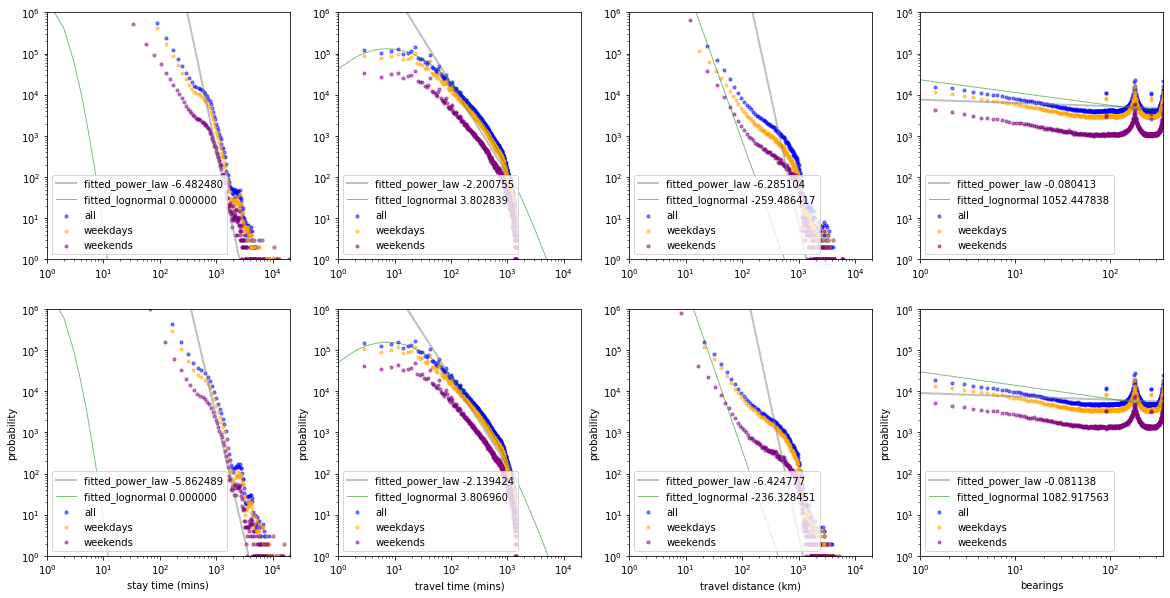

In [42]:
#######plotting their distrition


def interval_distribution_plot(df1,df2,savestr):
    fig, ((ax1, ax2,ax3,ax4), ( ax5,ax6,ax7,ax8)) = plt.subplots(2, 4, figsize=(20, 10))

    data_list=[list(df1['stay_t']),list(df1[df1['travel_t(min)'] != -1]['travel_t(min)']),list(df1[df1['travel_d(km)'] != -1]['travel_d(km)']),list(df1[df1['travel_beraing'] != -1]['travel_beraing'])]
    df_temp=df1[df1['weekdays'].isin([0,1,2,3,4])]
    data_list_weekday=[list(df_temp['stay_t']),list(df_temp[df_temp['travel_t(min)'] != -1]['travel_t(min)']),list(df_temp[df_temp['travel_d(km)'] != -1]['travel_d(km)']),list(df_temp[df_temp['travel_beraing'] != -1]['travel_beraing'])]
    df_tempx = df1[df1['weekdays'].isin([5,6])]
    data_list_weekend= [list(df_tempx['stay_t']), list(df_tempx[df_tempx['travel_t(min)'] != -1]['travel_t(min)']),list(df_tempx[df_tempx['travel_d(km)'] != -1]['travel_d(km)']),list(df_tempx[df_tempx['travel_beraing'] != -1]['travel_beraing'])]
    color_dict={'all':'blue','weekdays':'orange','weekends':'purple'}

    for data_all, labelx in zip([data_list,data_list_weekday,data_list_weekend],['all','weekdays','weekends']):
        for data,ax in zip(data_all,[ax1,ax2,ax3,ax4]):
            data=list(filter(lambda x: str(x) != 'nan', data))
            count, bins_count = np.histogram(data, bins=500)
            pdf = count #/ sum(count)
            ax.scatter(bins_count[1:], pdf, color=color_dict[labelx], alpha=0.5, s=10,label=labelx)
            if labelx=='all':
                a,b,xline,yline=fitting(list(bins_count[1:]), list(pdf))
                ax.plot(xline,yline,color='grey',linewidth=2,alpha=0.5,label='fitted_power_law %f'%a)
                a,x_line,y_line=fitting_lognormal(list(bins_count[1:]), list(pdf),data)
                ax.plot(x_line, y_line, 'g-',linewidth=1,alpha=0.5,label='fitted_lognormal %f'%a)


    data_list=[list(df2['stay_t']),list(df2[df2['travel_t(min)'] != -1]['travel_t(min)']),list(df2[df2['travel_d(km)'] != -1]['travel_d(km)']),list(df2[df2['travel_beraing'] != -1]['travel_beraing'])]
    df_temp=df2[df2['weekdays'].isin([0,1,2,3,4])]
    data_list_weekday=[list(df_temp['stay_t']),list(df_temp[df_temp['travel_t(min)'] != -1]['travel_t(min)']),list(df_temp[df_temp['travel_d(km)'] != -1]['travel_d(km)']),list(df_temp[df_temp['travel_beraing'] != -1]['travel_beraing'])]
    df_tempx = df2[df2['weekdays'].isin([5,6])]
    data_list_weekend= [list(df_tempx['stay_t']), list(df_tempx[df_tempx['travel_t(min)'] != -1]['travel_t(min)']),list(df_tempx[df_tempx['travel_d(km)'] != -1]['travel_d(km)']),list(df_tempx[df_tempx['travel_beraing'] != -1]['travel_beraing'])]
    color_dict={'all':'blue','weekdays':'orange','weekends':'purple'}

    for data_all, labelx in zip([data_list, data_list_weekday, data_list_weekend], ['all', 'weekdays', 'weekends']):
        for data, ax in zip(data_all, [ax5,ax6,ax7,ax8]):
            data=list(filter(lambda x: str(x) != 'nan', data))
            count, bins_count = np.histogram(data, bins=500)
            pdf = count #/ sum(count)
            ax.scatter(bins_count[1:], pdf, color=color_dict[labelx], alpha=0.5, s=10,label=labelx)
            if labelx == 'all':
                a, b, xline, yline = fitting(list(bins_count[1:]), list(pdf))
                ax.plot(xline, yline, color='grey', linewidth=2, alpha=0.5, label='fitted_power_law %f' % a)
                a, x_line, y_line = fitting_lognormal(list(bins_count[1:]), list(pdf), data)
                ax.plot(x_line, y_line, 'g-', linewidth=1, alpha=0.5, label='fitted_lognormal %f' % a)

    ax5.set_xlabel('stay time (mins)')
    ax5.set_ylabel('probability')
    ax6.set_xlabel('travel time (mins)')
    ax6.set_ylabel('probability')
    ax7.set_xlabel('travel distance (km)')
    ax7.set_ylabel('probability')
    ax8.set_xlabel('bearings')
    ax8.set_ylabel('probability')
    for ax in [ax1, ax2,ax3, ax5, ax6,ax7]:
        ax.legend(loc=3)
        ax.set_ylim(1, 1000000)
        ax.set_xlim(1, 20000)
        ax.set_xscale('log')
        ax.set_yscale('log')
    for ax in [ax4, ax8]:
        ax.legend(loc=3)
        ax.set_xlim(1,360)
        ax.set_ylim(1, 1000000)
        ax.set_xscale('log')
        ax.set_yscale('log')
    fig.savefig('Data_analyse/'+savestr+'.png', dpi=100)
    
print(df.columns)

df_before = df[df['date'].isin(date_list_before)]
df_after = df[df['date'].isin(date_list_after)]
print(len(df_before),len(df_after))

print('#############plotting travel_t, travel_d,stay_t,travel_angle###########')


interval_distribution_plot(df_before,df_after,'intervals_individuals_together')


0
3326032 3326032
1408.6 1417.3166666666666
end 33261
p-value -4.418601023715075 9.949856981411833e-06
1
3326032 3326032
1408.6 5293.999384767276
end 33261
p-value -14.819251132908075 1.3202865757646102e-49
2
3326032 3326032
1417.3166666666666 5293.999384767276
end 33261
p-value -1.140060100809466 0.25426536790363335


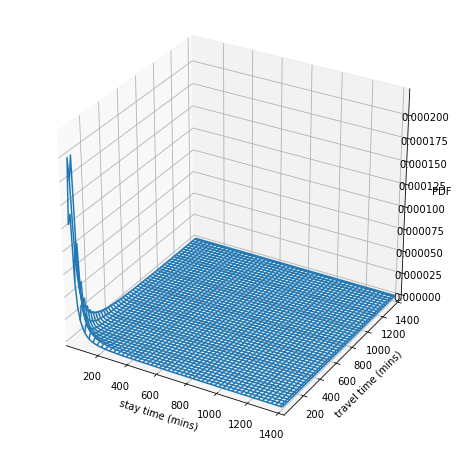

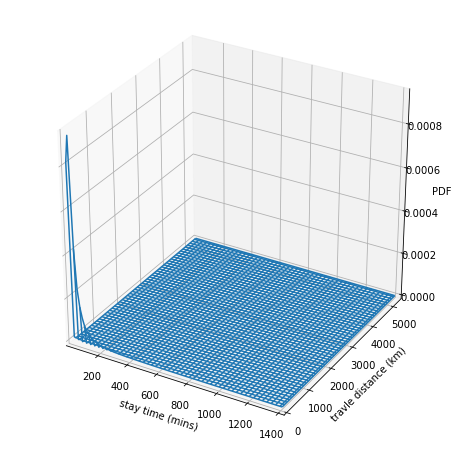

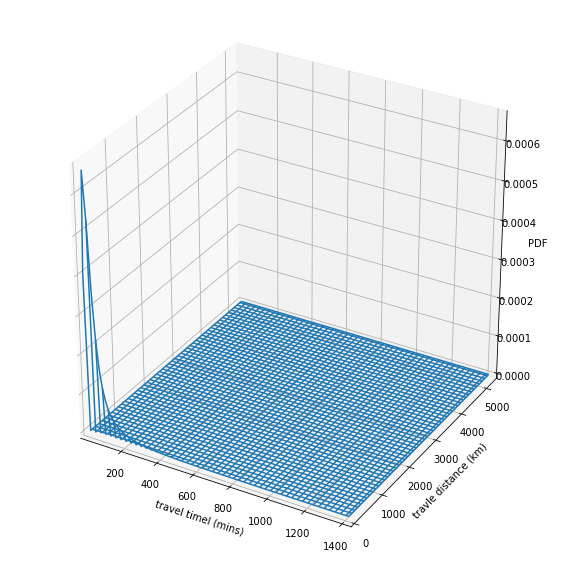

In [39]:
####plotting three_dimensional-file
X_data = list(df_after[df_after['travel_t(min)'] != -1]['stay_t'])
Y_data = list(df_after[df_after['travel_t(min)'] != -1]['travel_t(min)'])
Z_data=list(df_after[df_after['travel_d(km)'] != -1]['travel_d(km)'])

fig1 = plt.figure(figsize=(8, 8))
ax1= fig1.add_subplot(1, 1, 1, projection='3d')
fig2 = plt.figure(figsize=(8, 8))
ax2 = fig2.add_subplot(1, 1, 1, projection='3d')
fig3 = plt.figure(figsize=(8, 8))
ax3 = fig3.add_subplot(1, 1, 1, projection='3d')
count=0
for x,y,ax,slope1,slope2 in zip([X_data,X_data,Y_data],[Y_data,Z_data,Z_data],[ax1,ax2,ax3],[-2.09,-2.09,-2.15],[-2.15,-2.36,-2.36]):
    print(count)
    x=list(filter(lambda i: str(i) != 'nan', x))
    y=list(filter(lambda i: str(i) != 'nan', y))
    count+=1
    xmin, xmax =  np.min(x), np.max(x)
    ymin, ymax = np.min(y), np.max(y)
    print(len(x),len(y))
    print(xmax,ymax)
    # Peform the kernel density estimate
    import scipy.stats as st
    xx, yy = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    values = np.vstack([x, y])
    kernel = st.gaussian_kde(values)
    f = np.reshape(kernel(positions).T, xx.shape)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.plot_wireframe(xx, yy, f)

    small_x=xx[1][0]-xx[0][0]
    small_y = yy[0][1] - yy[0][0]
    True_value=[]
    for xi, yi in zip(x[::100], y[::100]):
        index_x=int(xi/small_x)
        index_y=int(yi/small_y)
        if int(xi/small_x)>=1000-1:
            index_x=999
        if int(yi/small_y)>=1000-1:
            index_y=999
        True_value.append(f[index_x][index_y])
    print('end',len(True_value))
    Estimated_value=[math.pow((xi+0.000000001),slope1)*math.pow((yi+0.000000001),slope2) for xi,yi in zip(x[::100],y[::100])]
    t, pval = scipy.stats.ttest_ind(True_value, Estimated_value)
    print('p-value',t, pval)


# Label plot
ax1.set_xlabel('stay time (mins)')
ax1.set_ylabel('travel time (mins)')
ax1.set_zlabel('PDF')
ax2.set_xlabel('stay time (mins)')
ax2.set_ylabel('travle distance (km)')
ax2.set_zlabel('PDF')
ax3.set_xlabel('travel timel (mins)')
ax3.set_ylabel('travle distance (km)')
ax3.set_zlabel('PDF')
plt.tight_layout()
plt.show()
fig1.savefig('Data_analyse/intervals_pairwise1.png', dpi=300)
fig2.savefig('Data_analyse/intervals_pairwise2.png', dpi=300)
fig3.savefig('Data_analyse/intervals_pairwise3.png', dpi=300)

## Section 2.3 trajectory_analyze(S(t),F(d),MSD(t))

In [ ]:

########Preprocess

df_frequency=pd.DataFrame()
result=[]
for indi in pd.unique(df['id_indiv']):
    if indi in df_demographic['id'].values:
        home_lon =df_demographic[df_demographic['id']==indi]['home_lon'].values[0]
        home_lat=df_demographic[df_demographic['id']==indi]['home_lat'].values[0]
        if home_lat!=' none' and home_lon!=' none':
            print(indi)
            df_temp=df[df['id_indiv']==indi]
            dict_label=Counter(df_temp['label'])
            df_temp=df_temp.drop_duplicates(subset=['label'])
            df_temp['t']=[int((datetime.datetime.fromtimestamp(j)-start_time).total_seconds()/3600) for j in df_temp['start'].values]
            df_temp['distance']=list(map(lambda x: distance(float(home_lat), float(home_lon), float(x[0]),float(x[1])), list(zip(df_temp['latitude'].values, df_temp['longitude'].values))))
            df_temp['frequency']=list(map(lambda x: dict_label[x], df_temp['label']))
            df_temp['far_home_20']= np.cumsum([1 if i>20  else 0 for i in df_temp['distance']])
            df_temp['far_home_100'] =  np.cumsum([1 if i > 100 else 0 for i in df_temp['distance']])
            df_temp['close_home_20'] = np.cumsum([1 if i <=20 else 0 for i in df_temp['distance']])
            df_temp['close_home_10'] = np.cumsum([1 if i <= 10 else 0 for i in df_temp['distance']])
            df_temp['cum_S'] = np.cumsum([1 for i in range(0,len(df_temp))])
            df_temp['cum_S_weekdays'] = np.cumsum([1 if datetime.datetime.fromtimestamp(i).weekday() in [0,1,2,3,4] else 0 for i in df_temp['start']])
            df_temp['cum_S_weekends'] = np.cumsum([1 if datetime.datetime.fromtimestamp(i).weekday() in [5,6] else 0 for i in df_temp['start']])
            df_temp['weekdays'] = [datetime.datetime.fromtimestamp(i).weekday() for i in df_temp['start']]
            result.append(df_temp)
df_frequency = pd.concat(result, ignore_index=True)

df_frequency.to_csv('/Volumes/SeagateDrive/Stoppoint_Individual/stopoints_all_with_frequency.csv')
    

In [ ]:

def frequency_plot(df_frequency,plot_name):
    
df_frequency=pd.read_csv('/Volumes/SeagateDrive/Stoppoint_Individual/stopoints_all_with_frequency.csv')
frequency_plot(df_frequency, 'before')

## Section 2.4 trajctory_analyze_social_interia

# Section 2.5 Routine/ Unrountine

In [ ]:
def check_routine(data):
    ###whether same location within 30m
    ###wheter same time wihtin 0.5h
    remove_index=[]
    left_index=[]
    for index1,row1 in data.iterrows():
        count=0
        remove_index_temp=[]
        remove_index_temp.append(index1)
        if index1 not in remove_index:
            for index2 in range(index1,len(data)):
                row2=data.loc[index2]
                if abs(row1['routine_time']-row2['routine_time'])<=0.5 and index1!=index2:
                    d,a=distance_compute(row1['latitude'],row1['latitude'],row2['latitude'],row2['latitude'])
                    if d<0.01:
                        #print(index1,index2,len(data), d,abs(row1['routine_time']-row2['routine_time']))
                        count+=1
                        remove_index_temp.append(index2)
        if len(remove_index_temp)>=2:
            remove_index=remove_index+remove_index_temp
        else:
            left_index.append(index1)
    return remove_index,left_index
                    
                    

def process_routine(df):
    start_date = datetime.datetime.strptime("2020-01-01", "%Y-%m-%d")
    df['routine_time']=[int((datetime.datetime.fromtimestamp(j)-start_date).total_seconds()/3600%24) for j in df['start'].values]
    print(df['routine_time'].max())
    remove_index_all=[]
    left_index_all=[]
    for indi in pd.unique(df['id_indiv']):
        print('indi',indi)
        data=df[df['id_indiv']==indi]
        remove_index,left_index=check_routine(data)
        remove_index_all=remove_index_all+remove_index
        left_index_all=left_index_all+left_index
    df_routine=df.loc[remove_index_all]
    df_unroutine=df.loc[left_index_all]
    return df_routine,df_unroutine
    

df_routine,df_unroutine=process_routine(df)

print(len(df_routine),len(df_unroutine))
#####Percentage of routine and unroutine
print('percentage of routine data is', len(df_routine)/(len(df_routine)+len(df_unroutine)))

23
indi 0
indi 1
indi 10
indi 100
indi 1000
indi 10000
indi 10001
indi 10003
indi 10004
indi 10005
indi 10006
indi 10008
indi 10009
indi 1001
indi 10011
indi 10012
indi 10013
indi 10015
indi 10016
indi 10018
indi 10020
indi 10021
indi 10022
indi 10023
indi 10024
indi 10025
indi 10026
indi 10027
indi 10028
indi 10029
indi 1003
indi 10030
indi 10031
indi 10032
indi 10033
indi 10034
indi 10035
indi 10036
indi 10037
indi 10038
indi 10039
indi 1004
indi 10040
indi 10041
indi 10042
indi 10043
indi 10044
indi 10046
indi 10047
indi 10048
indi 10049
indi 1005
indi 10050
indi 10051
indi 10053
indi 10056
indi 10057
indi 10058
indi 10059
indi 1006
indi 10060
indi 10061
indi 10062
indi 10064
indi 10065
indi 10066
indi 10067
indi 10069
indi 1007
indi 10070
indi 10071
indi 10072
indi 10074
indi 10075
indi 10076
indi 10077
indi 10078
indi 10079
indi 1008
indi 10080
indi 10081
indi 10082
indi 10084
indi 10085
indi 10086
indi 10088
indi 1009
indi 10090
indi 10091
indi 10092
indi 10093
indi 10094
indi 10

indi 10823
indi 10824
indi 10825
indi 10826
indi 10827
indi 10828
indi 10829
indi 1083
indi 10830
indi 10832
indi 10833
indi 10834
indi 10835
indi 10836
indi 10837
indi 10838
indi 10839
indi 1084
indi 10840
indi 10841
indi 10842
indi 10843
indi 10844
indi 10845
indi 10846
indi 10847
indi 10848
indi 10849
indi 1085
indi 10850
indi 10851
indi 10852
indi 10853
indi 10854
indi 10855
indi 10857
indi 10858
indi 1086
indi 10860
indi 10861
indi 10862
indi 10863
indi 10864
indi 10865
indi 10866
indi 10868
indi 10869
indi 10870
indi 10871
indi 10872
indi 10873
indi 10876
indi 10877
indi 10879
indi 1088
indi 10880
indi 10881
indi 10882
indi 10884
indi 10887
indi 1089
indi 10890
indi 10891
indi 10892
indi 10894
indi 10895
indi 10896
indi 10897
indi 10898
indi 10899
indi 109
indi 1090
indi 10901
indi 10902
indi 10903
indi 10904
indi 10906
indi 10907
indi 10908
indi 10909
indi 1091
indi 10910
indi 10911
indi 10912
indi 10914
indi 10915
indi 10916
indi 10917
indi 10918
indi 1092
indi 10920
indi 10921

indi 11651
indi 11652
indi 11653
indi 11654
indi 11656
indi 11659
indi 1166
indi 11661
indi 11663
indi 11664
indi 11665
indi 11666
indi 11667
indi 11669
indi 1167
indi 11670
indi 11671
indi 11673
indi 11674
indi 11676
indi 11677
indi 11678
indi 11679
indi 1168
indi 11681
indi 11682
indi 11683
indi 11684
indi 11685
indi 11686
indi 11687
indi 11688
indi 1169
indi 11690
indi 11691
indi 11692
indi 11693
indi 11694
indi 11695
indi 11696
indi 11697
indi 11698
indi 1170
indi 11700
indi 11701
indi 11702
indi 11703
indi 11704
indi 11705
indi 11706
indi 11707
indi 11708
indi 11709
indi 1171
indi 11711
indi 11712
indi 11713
indi 11714
indi 11716
indi 11717
indi 11718
indi 11719
indi 11720
indi 11721
indi 11722
indi 11723
indi 11724
indi 11725
indi 11726
indi 11727
indi 11728
indi 1173
indi 11732
indi 11733
indi 11734
indi 11735
indi 11736
indi 11739
indi 1174
indi 11743
indi 11744
indi 11745
indi 11746
indi 11747
indi 11748
indi 11749
indi 1175
indi 11751
indi 11752
indi 11753
indi 11754
indi 117

indi 12483
indi 12484
indi 12489
indi 1249
indi 12492
indi 12494
indi 12495
indi 12496
indi 12498
indi 12499
indi 125
indi 1250
indi 12500
indi 12501
indi 12502
indi 12503
indi 12505
indi 12506
indi 12507
indi 12508
indi 12509
indi 1251
indi 12510
indi 12511
indi 12512
indi 12513
indi 12514
indi 12516
indi 12517
indi 12518
indi 12519
indi 1252
indi 12520
indi 12522
indi 12523
indi 12525
indi 12526
indi 12529
indi 12532
indi 12534
indi 12537
indi 12538
indi 12539
indi 1254
indi 12540
indi 12541
indi 12543
indi 12547
indi 12548
indi 12549
indi 1255
indi 12550
indi 12551
indi 12552
indi 12553
indi 12554
indi 12555
indi 12556
indi 12557
indi 12558
indi 12559
indi 1256
indi 12560
indi 12561
indi 12562
indi 12564
indi 12565
indi 12566
indi 12567
indi 12568
indi 12569
indi 1257
indi 12570
indi 12571
indi 12572
indi 12573
indi 12574
indi 12575
indi 12576
indi 12577
indi 12579
indi 1258
indi 12580
indi 12581
indi 12583
indi 12584
indi 12585
indi 12586
indi 12588
indi 12591
indi 12592
indi 12593

indi 1333
indi 13331
indi 13332
indi 13333
indi 13334
indi 13336
indi 13337
indi 13338
indi 13339
indi 1334
indi 13340
indi 13342
indi 13343
indi 13344
indi 13345
indi 13346
indi 13347
indi 13348
indi 13349
indi 1335
indi 13351
indi 13352
indi 13353
indi 13355
indi 13356
indi 13357
indi 13358
indi 13359
indi 1336
indi 13360
indi 13361
indi 13362
indi 13364
indi 13365
indi 13366
indi 13367
indi 13369
indi 1337
indi 13370
indi 13371
indi 13373
indi 13374
indi 13375
indi 13376
indi 13377
indi 13378
indi 13379
indi 1338
indi 13381
indi 13382
indi 13384
indi 13385
indi 13387
indi 13388
indi 13389
indi 1339
indi 13390
indi 13393
indi 13395
indi 13396
indi 13397
indi 13398
indi 13399
indi 134
indi 13401
indi 13402
indi 13403
indi 13404
indi 13405
indi 13406
indi 13407
indi 13408
indi 13409
indi 1341
indi 13410
indi 13411
indi 13412
indi 13413
indi 13416
indi 13418
indi 13419
indi 1342
indi 13420
indi 13421
indi 13422
indi 13423
indi 13425
indi 13426
indi 13428
indi 13429
indi 1343
indi 13430


indi 1418
indi 14181
indi 14182
indi 14183
indi 14184
indi 14185
indi 14186
indi 14187
indi 14188
indi 14189
indi 1419
indi 14190
indi 14191
indi 14194
indi 14195
indi 14196
indi 14197
indi 14198
indi 14199
indi 142
indi 1420
indi 14200
indi 14201
indi 14202
indi 14203
indi 14204
indi 14205
indi 14206
indi 14207
indi 14208
indi 14209
indi 1421
indi 14210
indi 14211
indi 14212
indi 14213
indi 14215
indi 14216
indi 14217
indi 14218
indi 14219
indi 1422
indi 14221
indi 14222
indi 14223
indi 14224
indi 14226
indi 14228
indi 14229
indi 1423
indi 14230
indi 14232
indi 14233
indi 14236
indi 14237
indi 14238
indi 1424
indi 14240
indi 14241
indi 14242
indi 14243
indi 14244
indi 14245
indi 14247
indi 14248
indi 14249
indi 1425
indi 14250
indi 14251
indi 14253
indi 14254
indi 14255
indi 14256
indi 14257
indi 14258
indi 14259
indi 14260
indi 14262
indi 14263
indi 14264
indi 14265
indi 14266
indi 14268
indi 14269
indi 1427
indi 14270
indi 14273
indi 14275
indi 14276
indi 14277
indi 1428
indi 14280


indi 15030
indi 15031
indi 15033
indi 15035
indi 15036
indi 15038
indi 15039
indi 1504
indi 15041
indi 15043
indi 15045
indi 15046
indi 15047
indi 15048
indi 15049
indi 1505
indi 15050
indi 15051
indi 15052
indi 15054
indi 15055
indi 15057
indi 15058
indi 15059
indi 1506
indi 15061
indi 15062
indi 15063
indi 15064
indi 15066
indi 15067
indi 15068
indi 15069
indi 1507
indi 15070
indi 15071
indi 15072
indi 15073
indi 15074
indi 15075
indi 15076
indi 15077
indi 15078
indi 15079
indi 15080
indi 15081
indi 15085
indi 15086
indi 15087
indi 15088
indi 15089
indi 1509
indi 15090
indi 15091
indi 15092
indi 15094
indi 15095
indi 15097
indi 15098
indi 15099
indi 151
indi 1510
indi 15100
indi 15101
indi 15102
indi 15103
indi 15104
indi 15105
indi 15106
indi 15107
indi 15108
indi 15109
indi 15110
indi 15111
indi 15112
indi 15113
indi 15114
indi 15115
indi 15116
indi 15117
indi 15118
indi 15119
indi 1512
indi 15120
indi 15121
indi 15122
indi 15123
indi 15124
indi 15125
indi 15126
indi 1513
indi 1513

indi 15855
indi 15856
indi 15857
indi 15858
indi 15859
indi 1586
indi 15861
indi 15862
indi 15863
indi 15864
indi 15865
indi 15867
indi 15868
indi 1587
indi 15871
indi 15872
indi 15873
indi 15874
indi 15875
indi 15876
indi 15877
indi 15878
indi 15879
indi 1588
indi 15880
indi 15881
indi 15883
indi 15884
indi 15885
indi 15886
indi 15888
indi 15889
indi 1589
indi 15890
indi 15891
indi 15892
indi 15893
indi 15894
indi 15895
indi 15896
indi 15897
indi 15898
indi 15899
indi 159
indi 1590
indi 15900
indi 15901
indi 15902
indi 15903
indi 15905
indi 15906
indi 15907
indi 15908
indi 15909
indi 15910
indi 15912
indi 15913
indi 15914
indi 15915
indi 15918
indi 1592
indi 15920
indi 15921
indi 15922
indi 15923
indi 15924
indi 15925
indi 15926
indi 15927
indi 15928
indi 15929
indi 1593
indi 15930
indi 15931
indi 15932
indi 15935
indi 15936
indi 15937
indi 15938
indi 15939
indi 1594
indi 15940
indi 15941
indi 15942
indi 15944
indi 15945
indi 15947
indi 15948
indi 15949
indi 1595
indi 15951
indi 15952

indi 16692
indi 16693
indi 16694
indi 16695
indi 16696
indi 16699
indi 167
indi 16700
indi 16701
indi 16702
indi 16703
indi 16706
indi 16707
indi 16709
indi 1671
indi 16710
indi 16711
indi 16712
indi 16713
indi 16714
indi 16715
indi 16716
indi 16717
indi 16718
indi 16719
indi 1672
indi 16723
indi 16724
indi 16725
indi 16726
indi 16728
indi 16729
indi 1673
indi 16730
indi 16731
indi 16732
indi 16733
indi 16735
indi 16736
indi 16737
indi 16738
indi 16739
indi 1674
indi 16740
indi 16741
indi 16742
indi 16743
indi 16745
indi 16746
indi 16747
indi 16749
indi 16751
indi 16752
indi 16753
indi 16754
indi 16755
indi 16756
indi 16757
indi 16758
indi 16759
indi 1676
indi 16760
indi 16761
indi 16762
indi 16763
indi 16764
indi 16765
indi 16766
indi 16768
indi 16769
indi 1677
indi 16770
indi 16771
indi 16772
indi 16773
indi 16774
indi 16775
indi 16776
indi 16777
indi 16778
indi 16779
indi 16780
indi 16781
indi 16782
indi 16783
indi 16784
indi 16785
indi 16786
indi 16787
indi 16789
indi 16790
indi 16

indi 17523
indi 17524
indi 17525
indi 17526
indi 17527
indi 17528
indi 17529
indi 1753
indi 17530
indi 17531
indi 17532
indi 17533
indi 17535
indi 17536
indi 17537
indi 17538
indi 1754
indi 17540
indi 17541
indi 17542
indi 17543
indi 17544
indi 17545
indi 17546
indi 17547
indi 17548
indi 17549
indi 1755
indi 17550
indi 17551
indi 17552
indi 17553
indi 17556
indi 17557
indi 17558
indi 17559
indi 1756
indi 17560
indi 17561
indi 17562
indi 17563
indi 17564
indi 17565
indi 17566
indi 17567
indi 17568
indi 17569
indi 1757
indi 17570
indi 17571
indi 17572
indi 17573
indi 17575
indi 17576
indi 17577
indi 17578
indi 17579
indi 17580
indi 17581
indi 17582
indi 17583
indi 17584
indi 17585
indi 17586
indi 17587
indi 17588
indi 17589
indi 17590
indi 17591
indi 17594
indi 17595
indi 17596
indi 17597
indi 17598
indi 17599
indi 1760
indi 17600
indi 17601
indi 17602
indi 17603
indi 17604
indi 17605
indi 17607
indi 17609
indi 17610
indi 17611
indi 17612
indi 17613
indi 17614
indi 17616
indi 17618
indi 

indi 18354
indi 18356
indi 18357
indi 18358
indi 18359
indi 1836
indi 18360
indi 18361
indi 18362
indi 18363
indi 18365
indi 18366
indi 18368
indi 18369
indi 18370
indi 18371
indi 18372
indi 18373
indi 18376
indi 18377
indi 18378
indi 18379
indi 1838
indi 18380
indi 18382
indi 18384
indi 18385
indi 18386
indi 18387
indi 18388
indi 18389
indi 1839
indi 18390
indi 18391
indi 18392
indi 18393
indi 18394
indi 18395
indi 18396
indi 18397
indi 18399
indi 184
indi 1840
indi 18400
indi 18401
indi 18402
indi 18403
indi 18405
indi 18406
indi 18408
indi 1841
indi 18410
indi 18411
indi 18413
indi 18414
indi 18416
indi 18417
indi 18418
indi 1842
indi 18420
indi 18421
indi 18422
indi 18423
indi 18424
indi 18425
indi 18427
indi 18428
indi 18429
indi 1843
indi 18430
indi 18431
indi 18432
indi 18433
indi 18434
indi 18435
indi 18436
indi 18437
indi 18438
indi 18439
indi 18440
indi 18441
indi 18442
indi 18443
indi 18444
indi 18445
indi 18446
indi 18447
indi 18448
indi 18449
indi 1845
indi 18450
indi 1845

indi 19183
indi 19185
indi 19186
indi 19187
indi 1919
indi 19190
indi 19191
indi 19192
indi 19193
indi 19194
indi 19196
indi 19198
indi 192
indi 1920
indi 19200
indi 19201
indi 19202
indi 19204
indi 19206
indi 19207
indi 19208
indi 1921
indi 19210
indi 19211
indi 19212
indi 19214
indi 19215
indi 19216
indi 19217
indi 19219
indi 1922
indi 19221
indi 19222
indi 19224
indi 19225
indi 19226
indi 19227
indi 19228
indi 19229
indi 1923
indi 19230
indi 19231
indi 19232
indi 19233
indi 19234
indi 19235
indi 19236
indi 19237
indi 19238
indi 1924
indi 19240
indi 19241
indi 19243
indi 19244
indi 19245
indi 19246
indi 19247
indi 19248
indi 1925
indi 19250
indi 19252
indi 19253
indi 19254
indi 19255
indi 19257
indi 19258
indi 1926
indi 19261
indi 19262
indi 19263
indi 19264
indi 19265
indi 19266
indi 19267
indi 19268
indi 19269
indi 1927
indi 19271
indi 19272
indi 19274
indi 19276
indi 19277
indi 19278
indi 19279
indi 1928
indi 19281
indi 19283
indi 19285
indi 19286
indi 19287
indi 19288
indi 19289


indi 20016
indi 20017
indi 20019
indi 20020
indi 20021
indi 20022
indi 20025
indi 20026
indi 20027
indi 20028
indi 20029
indi 2003
indi 20030
indi 20031
indi 20032
indi 20034
indi 20036
indi 20037
indi 20038
indi 20039
indi 20040
indi 20042
indi 20043
indi 20045
indi 20046
indi 20047
indi 2005
indi 20050
indi 20051
indi 20052
indi 20053
indi 20054
indi 20055
indi 20056
indi 20057
indi 20058
indi 20059
indi 2006
indi 20060
indi 20061
indi 20062
indi 20063
indi 20064
indi 20065
indi 20066
indi 20067
indi 20068
indi 20069
indi 2007
indi 20073
indi 20075
indi 20076
indi 20077
indi 20078
indi 2008
indi 20080
indi 20081
indi 20082
indi 20083
indi 20084
indi 20086
indi 20087
indi 20088
indi 20089
indi 2009
indi 20090
indi 20091
indi 20092
indi 20093
indi 20097
indi 20098
indi 20099
indi 201
indi 2010
indi 20100
indi 20101
indi 20102
indi 20103
indi 20104
indi 20105
indi 20106
indi 20107
indi 20108
indi 2011
indi 20110
indi 20112
indi 20113
indi 20114
indi 20115
indi 20116
indi 20119
indi 2012

indi 20856
indi 20857
indi 20858
indi 20859
indi 2086
indi 20860
indi 20861
indi 20862
indi 20864
indi 20865
indi 20866
indi 20867
indi 2087
indi 20871
indi 20872
indi 20873
indi 20874
indi 20875
indi 20876
indi 20877
indi 20878
indi 2088
indi 20880
indi 20881
indi 20882
indi 20883
indi 20884
indi 20885
indi 20886
indi 20887
indi 20888
indi 20889
indi 2089
indi 20890
indi 20892
indi 20893
indi 20894
indi 20895
indi 20896
indi 20897
indi 20898
indi 20899
indi 209
indi 20900
indi 20901
indi 20902
indi 20903
indi 20904
indi 20906
indi 20907
indi 20908
indi 20909
indi 2091
indi 20910
indi 20911
indi 20912
indi 20913
indi 20916
indi 20917
indi 20919
indi 2092
indi 20920
indi 20922
indi 20925
indi 20926
indi 20927
indi 20928
indi 20929
indi 20930
indi 20931
indi 20932
indi 20934
indi 20935
indi 20936
indi 20937
indi 20939
indi 2094
indi 20940
indi 20942
indi 20943
indi 20944
indi 20945
indi 20948
indi 20949
indi 2095
indi 20951
indi 20953
indi 20954
indi 20955
indi 20957
indi 20958
indi 2095

indi 217
indi 2170
indi 21700
indi 21701
indi 21702
indi 21704
indi 21705
indi 21706
indi 21707
indi 21709
indi 2171
indi 21711
indi 21712
indi 21713
indi 21714
indi 21715
indi 21716
indi 21717
indi 21718
indi 2172
indi 21722
indi 21723
indi 21724
indi 21725
indi 21726
indi 21727
indi 21728
indi 21729
indi 2173
indi 21731
indi 21732
indi 21733
indi 21734
indi 21735
indi 21736
indi 21737
indi 21738
indi 2174
indi 21740
indi 21741
indi 21742
indi 21744
indi 21745
indi 21746
indi 21747
indi 21748
indi 2175
indi 21750
indi 21752
indi 21753
indi 21754
indi 21755
indi 21756
indi 21758
indi 2176
indi 21760
indi 21761
indi 21762
indi 21763
indi 21764
indi 21765
indi 21766
indi 21767
indi 21769
indi 2177
indi 21770
indi 21771
indi 21772
indi 21776
indi 21777
indi 21778
indi 21779
indi 2178
indi 21783
indi 21784
indi 21785
indi 21786
indi 21787
indi 21788
indi 21789
indi 2179
indi 21790
indi 21791
indi 21792
indi 21793
indi 21794
indi 21795
indi 21797
indi 21798
indi 21799
indi 218
indi 2180
ind

indi 22531
indi 22532
indi 22534
indi 22536
indi 22537
indi 22539
indi 2254
indi 22540
indi 22542
indi 22543
indi 22544
indi 22545
indi 22546
indi 22547
indi 22549
indi 2255
indi 22550
indi 22551
indi 22552
indi 22554
indi 22555
indi 22556
indi 22559
indi 2256
indi 22561
indi 22562
indi 22563
indi 22564
indi 22565
indi 22566
indi 22567
indi 22568
indi 22569
indi 2257
indi 22570
indi 22571
indi 22572
indi 22573
indi 22574
indi 22575
indi 22577
indi 22578
indi 22579
indi 2258
indi 22580
indi 22581
indi 22582
indi 22583
indi 22584
indi 22585
indi 22587
indi 22588
indi 22589
indi 2259
indi 22590
indi 22591
indi 22592
indi 22593
indi 22595
indi 22596
indi 22597
indi 22598
indi 22599
indi 226
indi 22600
indi 22601
indi 22602
indi 22603
indi 22604
indi 22605
indi 22606
indi 22607
indi 2261
indi 22610
indi 22611
indi 22612
indi 22613
indi 22614
indi 22615
indi 22616
indi 22618
indi 22619
indi 2262
indi 22620
indi 22621
indi 22622
indi 22623
indi 22624
indi 22625
indi 22626
indi 22627
indi 2262

indi 23353
indi 23354
indi 23356
indi 23357
indi 23359
indi 2336
indi 23360
indi 23361
indi 23362
indi 23363
indi 23364
indi 23366
indi 23367
indi 23368
indi 23369
indi 2337
indi 23370
indi 23372
indi 23373
indi 23374
indi 23375
indi 23377
indi 23378
indi 23379
indi 2338
indi 23380
indi 23381
indi 23383
indi 23384
indi 23386
indi 23387
indi 23388
indi 23389
indi 2339
indi 23390
indi 23391
indi 23392
indi 23394
indi 23395
indi 23396
indi 23397
indi 23398
indi 234
indi 2340
indi 23400
indi 23401
indi 23402
indi 23403
indi 23404
indi 23405
indi 23406
indi 23407
indi 23408
indi 23409
indi 2341
indi 23410
indi 23411
indi 23412
indi 23413
indi 23414
indi 23415
indi 23416
indi 23417
indi 23418
indi 23420
indi 23421
indi 23422
indi 23424
indi 23425
indi 23426
indi 23427
indi 23428
indi 23429
indi 2343
indi 23430
indi 23431
indi 23432
indi 23433
indi 23435
indi 23436
indi 23437
indi 23439
indi 2344
indi 23440
indi 23443
indi 23444
indi 23445
indi 23446
indi 23447
indi 23448
indi 23449
indi 2345

indi 24196
indi 24197
indi 24199
indi 242
indi 24200
indi 24201
indi 24202
indi 24203
indi 24204
indi 24205
indi 24207
indi 24208
indi 2421
indi 24210
indi 24211
indi 24212
indi 24213
indi 24214
indi 24216
indi 24217
indi 24218
indi 24219
indi 2422
indi 24220
indi 24222
indi 24223
indi 24224
indi 24225
indi 24226
indi 24228
indi 24229
indi 2423
indi 24231
indi 24232
indi 24233
indi 24234
indi 24235
indi 24237
indi 24238
indi 24239
indi 2424
indi 24240
indi 24241
indi 24242
indi 24243
indi 24244
indi 24245
indi 24246
indi 24247
indi 24248
indi 24249
indi 2425
indi 24250
indi 24251
indi 24252
indi 24253
indi 24254
indi 24256
indi 24257
indi 24258
indi 24259
indi 24260
indi 24261
indi 24262
indi 24263
indi 24264
indi 24265
indi 24266
indi 24267
indi 24268
indi 24269
indi 2427
indi 24271
indi 24272
indi 24273
indi 24274
indi 24275
indi 24276
indi 24277
indi 24278
indi 24279
indi 2428
indi 24280
indi 24281
indi 24282
indi 24283
indi 24284
indi 24285
indi 24286
indi 24287
indi 24288
indi 242

indi 25033
indi 25034
indi 25035
indi 25036
indi 25037
indi 25038
indi 25039
indi 2504
indi 25040
indi 25041
indi 25042
indi 25043
indi 25044
indi 25045
indi 25047
indi 25048
indi 25049
indi 2505
indi 25051
indi 25052
indi 25053
indi 25056
indi 25057
indi 25058
indi 25059
indi 2506
indi 25060
indi 25061
indi 25062
indi 25063
indi 25065
indi 25066
indi 25067
indi 25069
indi 2507
indi 25070
indi 25075
indi 25076
indi 25077
indi 25078
indi 25079
indi 2508
indi 25080
indi 25081
indi 25083
indi 25084
indi 25086
indi 25087
indi 25088
indi 25089
indi 2509
indi 25090
indi 25091
indi 25092
indi 25093
indi 25094
indi 25095
indi 25096
indi 25097
indi 25100
indi 25101
indi 25102
indi 25103
indi 25104
indi 25106
indi 25107
indi 25108
indi 25109
indi 2511
indi 25111
indi 25112
indi 25113
indi 25114
indi 25115
indi 25117
indi 25119
indi 2512
indi 25120
indi 25121
indi 25122
indi 25123
indi 25125
indi 25126
indi 25128
indi 25129
indi 2513
indi 25131
indi 25135
indi 25136
indi 25137
indi 25138
indi 251

indi 25857
indi 25858
indi 25859
indi 2586
indi 25860
indi 25861
indi 25862
indi 25863
indi 25865
indi 25866
indi 25867
indi 25868
indi 25869
indi 25870
indi 25871
indi 25872
indi 25873
indi 25874
indi 25875
indi 25876
indi 25877
indi 25878
indi 2588
indi 25880
indi 25883
indi 25884
indi 25885
indi 25886
indi 25887
indi 25889
indi 2589
indi 25890
indi 25891
indi 25892
indi 25893
indi 25894
indi 25895
indi 25896
indi 25897
indi 25898
indi 259
indi 2590
indi 25900
indi 25901
indi 25902
indi 25904
indi 25905
indi 25907
indi 25909
indi 2591
indi 25910
indi 25911
indi 25912
indi 25913
indi 25914
indi 25915
indi 25916
indi 25917
indi 25918
indi 25919
indi 2592
indi 25920
indi 25921
indi 25922
indi 25923
indi 25924
indi 25925
indi 25926
indi 25928
indi 25929
indi 2593
indi 25930
indi 25931
indi 25932
indi 25933
indi 25934
indi 25935
indi 25937
indi 25938
indi 25939
indi 2594
indi 25940
indi 25941
indi 25942
indi 25944
indi 25945
indi 25947
indi 25948
indi 25949
indi 2595
indi 25950
indi 25951

indi 26683
indi 26684
indi 26685
indi 26686
indi 26687
indi 26688
indi 26689
indi 26690
indi 26691
indi 26692
indi 26693
indi 26694
indi 26695
indi 26696
indi 267
indi 2670
indi 26700
indi 26701
indi 26702
indi 26703
indi 26704
indi 26705
indi 26706
indi 26709
indi 2671
indi 26710
indi 26711
indi 26712
indi 26713
indi 26715
indi 26716
indi 26717
indi 26718
indi 26719
indi 2672
indi 26720
indi 26721
indi 26722
indi 26723
indi 26724
indi 26725
indi 26726
indi 26727
indi 26728
indi 26729
indi 2673
indi 26731
indi 26732
indi 26734
indi 26735
indi 26737
indi 26738
indi 26739
indi 2674
indi 26740
indi 26741
indi 26742
indi 26743
indi 26745
indi 26746
indi 26747
indi 26748
indi 26749
indi 2675
indi 26750
indi 26751
indi 26752
indi 26753
indi 26754
indi 26755
indi 26756
indi 26758
indi 2676
indi 26760
indi 26762
indi 26764
indi 26766
indi 26767
indi 26768
indi 26769
indi 2677
indi 26770
indi 26771
indi 26772
indi 26773
indi 26774
indi 26775
indi 26776
indi 26777
indi 26778
indi 26779
indi 2678

indi 27520
indi 27521
indi 27522
indi 27523
indi 27524
indi 27525
indi 27526
indi 27529
indi 2753
indi 27530
indi 27531
indi 27533
indi 27534
indi 27535
indi 27536
indi 27538
indi 27539
indi 2754
indi 27540
indi 27541
indi 27542
indi 27543
indi 27544
indi 27545
indi 27546
indi 2755
indi 27550
indi 27551
indi 27552
indi 27553
indi 27554
indi 27555
indi 27556
indi 27557
indi 27558
indi 27559
indi 2756
indi 27560
indi 27561
indi 27562
indi 27563
indi 27564
indi 27565
indi 27566
indi 27568
indi 27569
indi 2757
indi 27570
indi 27572
indi 27574
indi 27575
indi 27576
indi 27577
indi 27579
indi 2758
indi 27580
indi 27581
indi 27582
indi 27583
indi 27584
indi 27585
indi 27587
indi 27588
indi 27590
indi 27591
indi 27592
indi 27593
indi 27594
indi 27595
indi 27596
indi 27597
indi 27599
indi 276
indi 27600
indi 27601
indi 27602
indi 27603
indi 27604
indi 27605
indi 27606
indi 27607
indi 27608
indi 27609
indi 2761
indi 27610
indi 27611
indi 27613
indi 27614
indi 27615
indi 27616
indi 27617
indi 276

indi 28342
indi 28343
indi 28344
indi 28345
indi 28346
indi 28347
indi 28348
indi 28349
indi 2835
indi 28350
indi 28351
indi 28352
indi 28353
indi 28354
indi 28355
indi 28356
indi 28357
indi 28358
indi 28359
indi 28361
indi 28363
indi 28364
indi 28365
indi 28369
indi 2837
indi 28370
indi 28371
indi 28372
indi 28374
indi 28375
indi 28376
indi 28377
indi 28378
indi 2838
indi 28380
indi 28381
indi 28382
indi 28383
indi 28384
indi 28385
indi 28386
indi 28387
indi 28388
indi 28389
indi 2839
indi 28390
indi 28391
indi 28393
indi 28395
indi 28397
indi 28398
indi 28399
indi 284
indi 2840
indi 28400
indi 28401
indi 28402
indi 28403
indi 28404
indi 28405
indi 28406
indi 28407
indi 28408
indi 28409
indi 2841
indi 28410
indi 28411
indi 28412
indi 28414
indi 28415
indi 28416
indi 28417
indi 28418
indi 28419
indi 2842
indi 28420
indi 28421
indi 28422
indi 28423
indi 28424
indi 28425
indi 28426
indi 28427
indi 28428
indi 28430
indi 28431
indi 28432
indi 28433
indi 28435
indi 28436
indi 28437
indi 284

indi 29183
indi 29185
indi 29186
indi 29188
indi 29189
indi 2919
indi 29190
indi 29191
indi 29192
indi 29193
indi 29194
indi 29199
indi 292
indi 2920
indi 29200
indi 29201
indi 29203
indi 29204
indi 29205
indi 29206
indi 29207
indi 29209
indi 2921
indi 29210
indi 29211
indi 29212
indi 29215
indi 29216
indi 29218
indi 29219
indi 2922
indi 29220
indi 29223
indi 29224
indi 29225
indi 29226
indi 29227
indi 29228
indi 29229
indi 2923
indi 29231
indi 29232
indi 29233
indi 29235
indi 29236
indi 29238
indi 29239
indi 2924
indi 29241
indi 29242
indi 29243
indi 29244
indi 29245
indi 29246
indi 29247
indi 29248
indi 29249
indi 2925
indi 29250
indi 29251
indi 29252
indi 29253
indi 29254
indi 29255
indi 29256
indi 29258
indi 2926
indi 29261
indi 29262
indi 29263
indi 29264
indi 29265
indi 29266
indi 29267
indi 29268
indi 29269
indi 2927
indi 29270
indi 29271
indi 29272
indi 29273
indi 29274
indi 29275
indi 29276
indi 29277
indi 29278
indi 29279
indi 2928
indi 29280
indi 29281
indi 29282
indi 29283


indi 30019
indi 3002
indi 30020
indi 30021
indi 30022
indi 30024
indi 30025
indi 30026
indi 30027
indi 30029
indi 3003
indi 30031
indi 30034
indi 30035
indi 30036
indi 30037
indi 30038
indi 30040
indi 30041
indi 30042
indi 30045
indi 30046
indi 30048
indi 30049
indi 3005
indi 30050
indi 30051
indi 30052
indi 30053
indi 30055
indi 30057
indi 30058
indi 3006
indi 30060
indi 30061
indi 30062
indi 30063
indi 30066
indi 30067
indi 30069
indi 3007
indi 30070
indi 30071
indi 30072
indi 30073
indi 30074
indi 30075
indi 30076
indi 30078
indi 30079
indi 3008
indi 30081
indi 30082
indi 30083
indi 30084
indi 30085
indi 30087
indi 30089
indi 3009
indi 30090
indi 30091
indi 30092
indi 30093
indi 30094
indi 30096
indi 30098
indi 30099
indi 301
indi 3010
indi 30101
indi 30103
indi 30105
indi 30106
indi 30107
indi 30109
indi 3011
indi 30110
indi 30111
indi 30112
indi 30113
indi 30115
indi 30116
indi 30117
indi 30119
indi 3012
indi 30120
indi 30121
indi 30122
indi 30123
indi 30124
indi 30125
indi 30126


indi 30870
indi 30871
indi 30873
indi 30874
indi 30875
indi 30876
indi 30877
indi 30878
indi 30880
indi 30881
indi 30882
indi 30884
indi 30885
indi 30886
indi 30887
indi 30888
indi 30889
indi 30890
indi 30891
indi 30892
indi 30894
indi 30895
indi 30897
indi 30899
indi 309
indi 3090
indi 30900
indi 30901
indi 30902
indi 30904
indi 30905
indi 30907
indi 30908
indi 30909
indi 3091
indi 30911
indi 30912
indi 30913
indi 30914
indi 30915
indi 30916
indi 30917
indi 30918
indi 30919
indi 3092
indi 30920
indi 30921
indi 30922
indi 30923
indi 30924
indi 30925
indi 30926
indi 30927
indi 30928
indi 30929
indi 3093
indi 30930
indi 30931
indi 30932
indi 30933
indi 30934
indi 30935
indi 30937
indi 30938
indi 30939
indi 3094
indi 30940
indi 30941
indi 30942
indi 30943
indi 30944
indi 30946
indi 30947
indi 30948
indi 30949
indi 3095
indi 30950
indi 30952
indi 30953
indi 30954
indi 30955
indi 30956
indi 30957
indi 30958
indi 30960
indi 30962
indi 30963
indi 30964
indi 30966
indi 30967
indi 30968
indi 30

indi 31732
indi 31734
indi 31735
indi 31736
indi 31737
indi 31738
indi 31739
indi 31740
indi 31741
indi 31742
indi 31744
indi 31745
indi 31746
indi 31748
indi 31749
indi 3175
indi 31750
indi 31752
indi 31753
indi 31754
indi 31755
indi 31756
indi 31759
indi 3176
indi 31760
indi 31761
indi 31762
indi 31763
indi 31764
indi 31765
indi 31766
indi 31767
indi 31768
indi 31769
indi 3177
indi 31770
indi 31771
indi 31772
indi 31773
indi 31774
indi 31775
indi 31776
indi 31777
indi 31778
indi 31779
indi 3178
indi 31780
indi 31781
indi 31782
indi 31783
indi 31784
indi 31785
indi 31786
indi 31787
indi 31788
indi 31789
indi 31790
indi 31791
indi 31792
indi 31793
indi 31794
indi 31795
indi 31796
indi 31798
indi 31799
indi 318
indi 3180
indi 31800
indi 31801
indi 31802
indi 31803
indi 31806
indi 31807
indi 31808
indi 31809
indi 3181
indi 31810
indi 31811
indi 31812
indi 31813
indi 31814
indi 31815
indi 31816
indi 31817
indi 31818
indi 31820
indi 31821
indi 31822
indi 31823
indi 31824
indi 31825
indi 31

indi 32562
indi 32563
indi 32564
indi 32565
indi 32566
indi 32567
indi 32568
indi 32569
indi 3257
indi 32570
indi 32571
indi 32572
indi 32573
indi 32575
indi 32576
indi 32577
indi 32578
indi 32579
indi 3258
indi 32580
indi 32582
indi 32583
indi 32584
indi 32585
indi 32586
indi 32587
indi 32588
indi 32589
indi 32590
indi 32591
indi 32592
indi 32595
indi 32596
indi 32597
indi 32598
indi 326
indi 3260
indi 32600
indi 32602
indi 32603
indi 32604
indi 32605
indi 32607
indi 32608
indi 32609
indi 32610
indi 32613
indi 32614
indi 32615
indi 32616
indi 32617
indi 3262
indi 32620
indi 32621
indi 32622
indi 32623
indi 32624
indi 32626
indi 32627
indi 32629
indi 32630
indi 32631
indi 32632
indi 32633
indi 32634
indi 32635
indi 32636
indi 32637
indi 32639
indi 32641
indi 32642
indi 32644
indi 32645
indi 32646
indi 32647
indi 32648
indi 32649
indi 32651
indi 32652
indi 32653
indi 32654
indi 32655
indi 32656
indi 32657
indi 32659
indi 32660
indi 32661
indi 32662
indi 32663
indi 32665
indi 32666
indi 

indi 33384
indi 33385
indi 33386
indi 33387
indi 33388
indi 33389
indi 3339
indi 33390
indi 33391
indi 33392
indi 33394
indi 33396
indi 33398
indi 33399
indi 334
indi 3340
indi 33400
indi 33401
indi 33402
indi 33403
indi 33404
indi 33405
indi 33406
indi 33407
indi 33409
indi 3341
indi 33410
indi 33411
indi 33412
indi 33414
indi 33415
indi 33416
indi 33417
indi 33418
indi 33419
indi 3342
indi 33420
indi 33422
indi 33423
indi 33425
indi 33426
indi 33428
indi 3343
indi 33430
indi 33431
indi 33432
indi 33434
indi 33435
indi 33436
indi 33437
indi 33438
indi 33439
indi 3344
indi 33440
indi 33441
indi 33442
indi 33443
indi 33444
indi 33445
indi 33448
indi 33449
indi 3345
indi 33450
indi 33451
indi 33452
indi 33453
indi 33455
indi 33457
indi 33458
indi 33459
indi 3346
indi 33460
indi 33461
indi 33462
indi 33464
indi 33465
indi 33469
indi 3347
indi 33470
indi 33471
indi 33473
indi 33474
indi 33475
indi 33476
indi 33477
indi 33478
indi 33479
indi 33480
indi 33482
indi 33483
indi 33484
indi 33485

indi 3424
indi 34240
indi 34241
indi 34242
indi 34243
indi 34245
indi 34246
indi 34247
indi 34249
indi 3425
indi 34250
indi 34251
indi 34253
indi 34256
indi 34257
indi 34258
indi 34259
indi 3426
indi 34260
indi 34262
indi 34263
indi 34264
indi 34265
indi 34266
indi 34267
indi 34269
indi 3427
indi 34270
indi 34271
indi 34272
indi 34273
indi 34274
indi 34275
indi 34276
indi 34277
indi 34278
indi 34279
indi 3428
indi 34280
indi 34281
indi 34282
indi 34283
indi 34284
indi 34285
indi 34286
indi 34287
indi 34288
indi 34289
indi 3429
indi 34290
indi 34291
indi 34293
indi 34294
indi 34295
indi 34296
indi 34297
indi 34298
indi 34299
indi 343
indi 3430
indi 34300
indi 34301
indi 34302
indi 34303
indi 34305
indi 34306
indi 34308
indi 34309
indi 3431
indi 34310
indi 34311
indi 34313
indi 34314
indi 34316
indi 34317
indi 34318
indi 34319
indi 3432
indi 34322
indi 34323
indi 34324
indi 34325
indi 34327
indi 34328
indi 34329
indi 3433
indi 34330
indi 34331
indi 34332
indi 34333
indi 34334
indi 34335


indi 35081
indi 35082
indi 35083
indi 35084
indi 35085
indi 35086
indi 35087
indi 35088
indi 3509
indi 35090
indi 35091
indi 35092
indi 35093
indi 35094
indi 35095
indi 35096
indi 35097
indi 35098
indi 35099
indi 3510
indi 35100
indi 35101
indi 35104
indi 35105
indi 35106
indi 35107
indi 35108
indi 35109
indi 3511
indi 35110
indi 35111
indi 35112
indi 35113
indi 35114
indi 35115
indi 35116
indi 35117
indi 3512
indi 35121
indi 35122
indi 35123
indi 35124
indi 35127
indi 3513
indi 35130
indi 35131
indi 35132
indi 35133
indi 35134
indi 35135
indi 35136
indi 35137
indi 35138
indi 35139
indi 3514
indi 35140
indi 35141
indi 35142
indi 35143
indi 35144
indi 35145
indi 35146
indi 35147
indi 35148
indi 35149
indi 35150
indi 35151
indi 35152
indi 35154
indi 35155
indi 35157
indi 35158
indi 35159
indi 3516
indi 35160
indi 35163
indi 35164
indi 35165
indi 35166
indi 35167
indi 35169
indi 3517
indi 35170
indi 35171
indi 35172
indi 35173
indi 35175
indi 35176
indi 35178
indi 35179
indi 3518
indi 351

indi 35955
indi 35956
indi 3596
indi 35960
indi 35961
indi 35962
indi 35963
indi 35964
indi 35966
indi 35967
indi 35968
indi 35969
indi 35970
indi 35971
indi 35972
indi 35973
indi 35975
indi 35976
indi 35977
indi 35978
indi 35979
indi 3598
indi 35980
indi 35981
indi 35982
indi 35983
indi 35984
indi 35985
indi 35987
indi 3599
indi 35991
indi 35992
indi 35993
indi 35994
indi 35995
indi 35996
indi 35997
indi 35998
indi 35999
indi 360
indi 36000
indi 36001
indi 36002
indi 36003
indi 36004
indi 36007
indi 36008
indi 36009
indi 3601
indi 36010
indi 36012
indi 36013
indi 36014
indi 36015
indi 36017
indi 36018
indi 36019
indi 3602
indi 36021
indi 36022
indi 36023
indi 36024
indi 36025
indi 36026
indi 36027
indi 36029
indi 3603
indi 36031
indi 36032
indi 36033
indi 36034
indi 36035
indi 36036
indi 36040
indi 36047
indi 3605
indi 36053
indi 3606
indi 36061
indi 36066
indi 3607
indi 36073
indi 36079
indi 3608
indi 36087
indi 3609
indi 36092
indi 36098
indi 3610
indi 36101
indi 36103
indi 36104
in

indi 36899
indi 369
indi 3690
indi 36900
indi 36901
indi 36902
indi 36903
indi 36904
indi 36905
indi 36906
indi 36908
indi 36909
indi 3691
indi 36910
indi 36911
indi 36913
indi 36916
indi 36917
indi 36918
indi 36919
indi 3692
indi 36920
indi 36922
indi 36923
indi 36924
indi 36925
indi 36927
indi 36928
indi 3693
indi 36930
indi 36931
indi 36932
indi 36933
indi 36934
indi 36935
indi 36936
indi 36937
indi 36938
indi 36939
indi 36942
indi 36943
indi 36945
indi 36946
indi 36947
indi 36948
indi 36950
indi 36951
indi 36952
indi 36953
indi 36954
indi 36955
indi 36956
indi 36957
indi 36958
indi 36959
indi 3696
indi 36960
indi 36962
indi 36966
indi 36967
indi 36968
indi 36969
indi 3697
indi 36970
indi 36971
indi 36972
indi 36973
indi 36974
indi 36975
indi 36977
indi 36978
indi 3698
indi 36980
indi 36981
indi 36982
indi 36985
indi 36986
indi 36987
indi 36988
indi 36989
indi 3699
indi 36990
indi 36991
indi 36992
indi 36993
indi 36995
indi 36996
indi 36997
indi 36999
indi 370
indi 3700
indi 37000
i

#############plotting travel_t, travel_d,stay_t,travel_angle###########
2.8105836880757447 3.118381063441555 0.5423113239144516
6.123411609489833 1.4968514009416152 0.10827686672881945
153.95940843243798 -3.88292756383758 0.3270114781536944
1.2635939481912182e+18 99.55185260629949 10.977573655451101
7052496.0 0.0 0.5
17597326.484960783 3.8042940173467996 1.3402424941867777
9.540715038814485e+167 -248.0383672005028 9.264064291446356
1.161973891738923e+165 1068.5696039311038 39.57082830047098


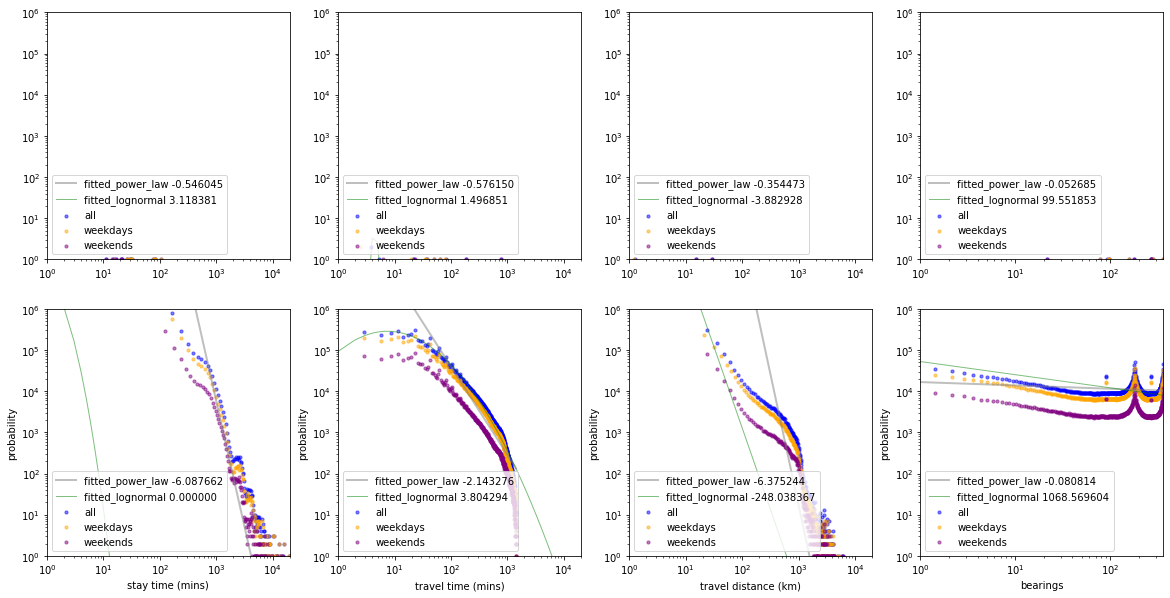

In [69]:
######plotting
df_routine = pd.DataFrame(data=df_routine, columns=df.columns)

print('#############plotting travel_t, travel_d,stay_t,travel_angle###########')

interval_distribution_plot(df_routine,df_unroutine,'intervals_individuals_rountine')







# Section 3. Visitaion_law